In [1]:
library("here")
library(devtools)
library(Seurat)
library(Socrates)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/proso_millet_v2/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl

In [2]:
rep_1 <- paste0(data_path,"Proso_millet.sciATAC.JP_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Proso_millet.sciATAC.sz_QC_soc_obj.rds")
prefix <- "Pm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("JP", "SZ")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [3]:
library(tidyverse)
as_tibble(merged.obj$meta)  %>% 
    group_by(sampleID)  %>% 
    summarise(mean_total = mean(total),
                           mean_tss = mean(tss),
                            mean_acrs = mean(acrs),
             mean_nSites = mean(nSites))

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dpl

sampleID mean_total mean_tss  mean_acrs mean_nSites
1 JP       1023.655    399.1394  570.1113  597.8952  
2 SZ       2562.918   1130.1395 1589.7842 1258.6935

In [4]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"2 x values <= 0 omitted from logarithmic plot"


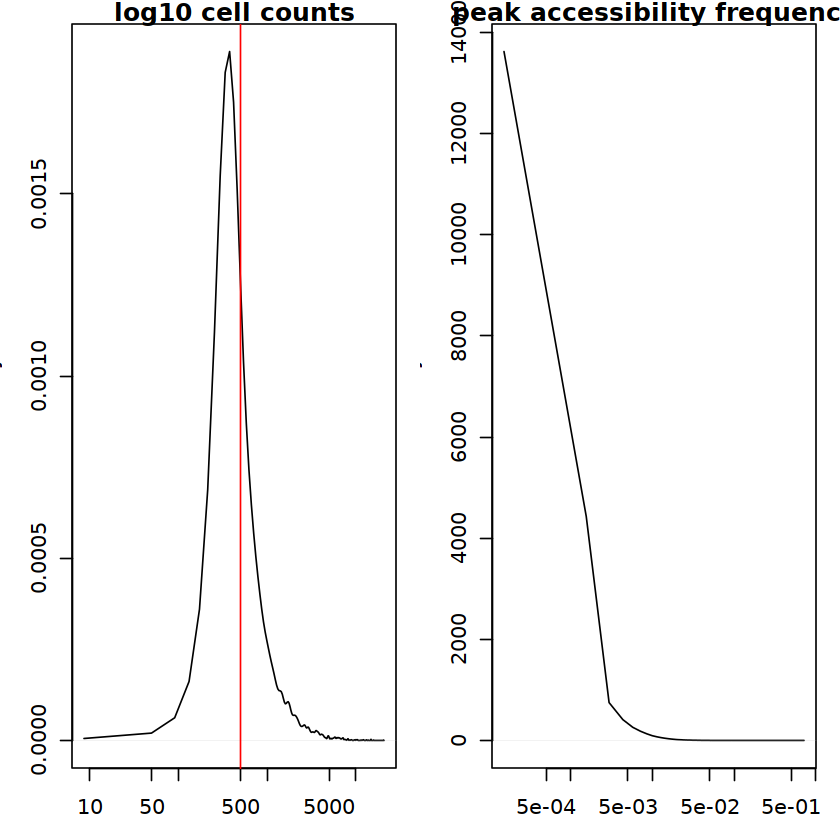

In [6]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [7]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.001, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 4761 | peaks = 731043

   * Filtered: cells = 4560 | peaks = 37851



In [8]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

In [9]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="NMF", 
                      n.pcs=20, 
                      num.var=30000,
                      svd_slotName="NMF")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="NMF")

 - non-linear dimensionality reduction with UMAP ...

11:49:53 UMAP embedding parameters a = 1.896 b = 0.8006

11:49:53 Read 4560 rows and found 20 numeric columns

11:49:53 Using Annoy for neighbor search, n_neighbors = 25

11:49:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:49:54 Writing NN index file to temp file /tmp/RtmpsjVwJo/file2436674db9f63

11:49:54 Searching Annoy index using 16 threads, search_k = 2500

11:49:54 Annoy recall = 100%

11:49:56 Commencing smooth kNN distance calibration using 16 threads

11:49:57 Initializing from normalized Laplacian + noise

11:49:57 Commencing optimization for 500 epochs, with 153508 positive edges

11:50:10 Optimization finished



In [12]:
str(soc.obj.project_umap)

List of 10
 $ meta       :'data.frame':	22162 obs. of  10 variables:
  ..$ cellID     : chr [1:22162] "BC:Z:CGATGTAGTCAACTAAGATGAGCACTAA-Proso_C1_G017_10x.rep1" "BC:Z:CGATGTGATCAGTCGCGGTTTCGCGAGG-Proso_C1_G017_10x.rep1" "BC:Z:TTAGGCTAGCTTCAATTATGAGCAACAT-Proso_C9_G017_10x.rep1" "BC:Z:CGATGTCCGTCCCTAAGACTGATACTAA-Proso_C1_G017_10x.rep1" ...
  ..$ total      : num [1:22162] 120154 94162 90645 87752 85691 ...
  ..$ tss        : num [1:22162] 50584 39140 37596 37625 35974 ...
  ..$ acrs       : num [1:22162] 96676 76176 74160 65384 68481 ...
  ..$ ptmt       : num [1:22162] NA NA NA NA NA NA NA NA NA NA ...
  ..$ nSites     : num [1:22162] 52496 43924 40448 38822 39936 ...
  ..$ log10nSites: num [1:22162] 4.72 4.64 4.61 4.59 4.6 ...
  ..$ sampleID   : chr [1:22162] "rep1" "rep1" "rep1" "rep1" ...
  ..$ umap1      : num [1:22162] 6.675 7.786 -1.613 0.558 -7.081 ...
  ..$ umap2      : num [1:22162] -2.737 -0.622 1.633 3.592 -1.959 ...
 $ counts     :Formal class 'dgCMatrix' [package "Matrix"

In [10]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "NMF", svd_slotName="NMF")

 - Creating synthetic doublets ...

 - Created 20000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [11]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [12]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    
    new_meta <- subset(old_meta, doubletscore < remove_val_greater) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [13]:
library(tidyverse)

#Generate Graphs for Comparison of Doublets
birthday_problem <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
birthday_problem_graph <- ggplot(birthday_problem, aes(doubletscore, color = filter_bool)) + 
geom_bar() + 
facet_grid(sampleID~.) + 
ggtitle("Birthday Problem")

archR_graph_1 <- as_tibble(tfidf.obj.dob.filt$meta) %>% 
    ggplot(., aes(doubletscore, color = d.type)) + geom_bar() + facet_grid(sampleID~.) + 
    ggtitle("ArchR Doublet Calls")

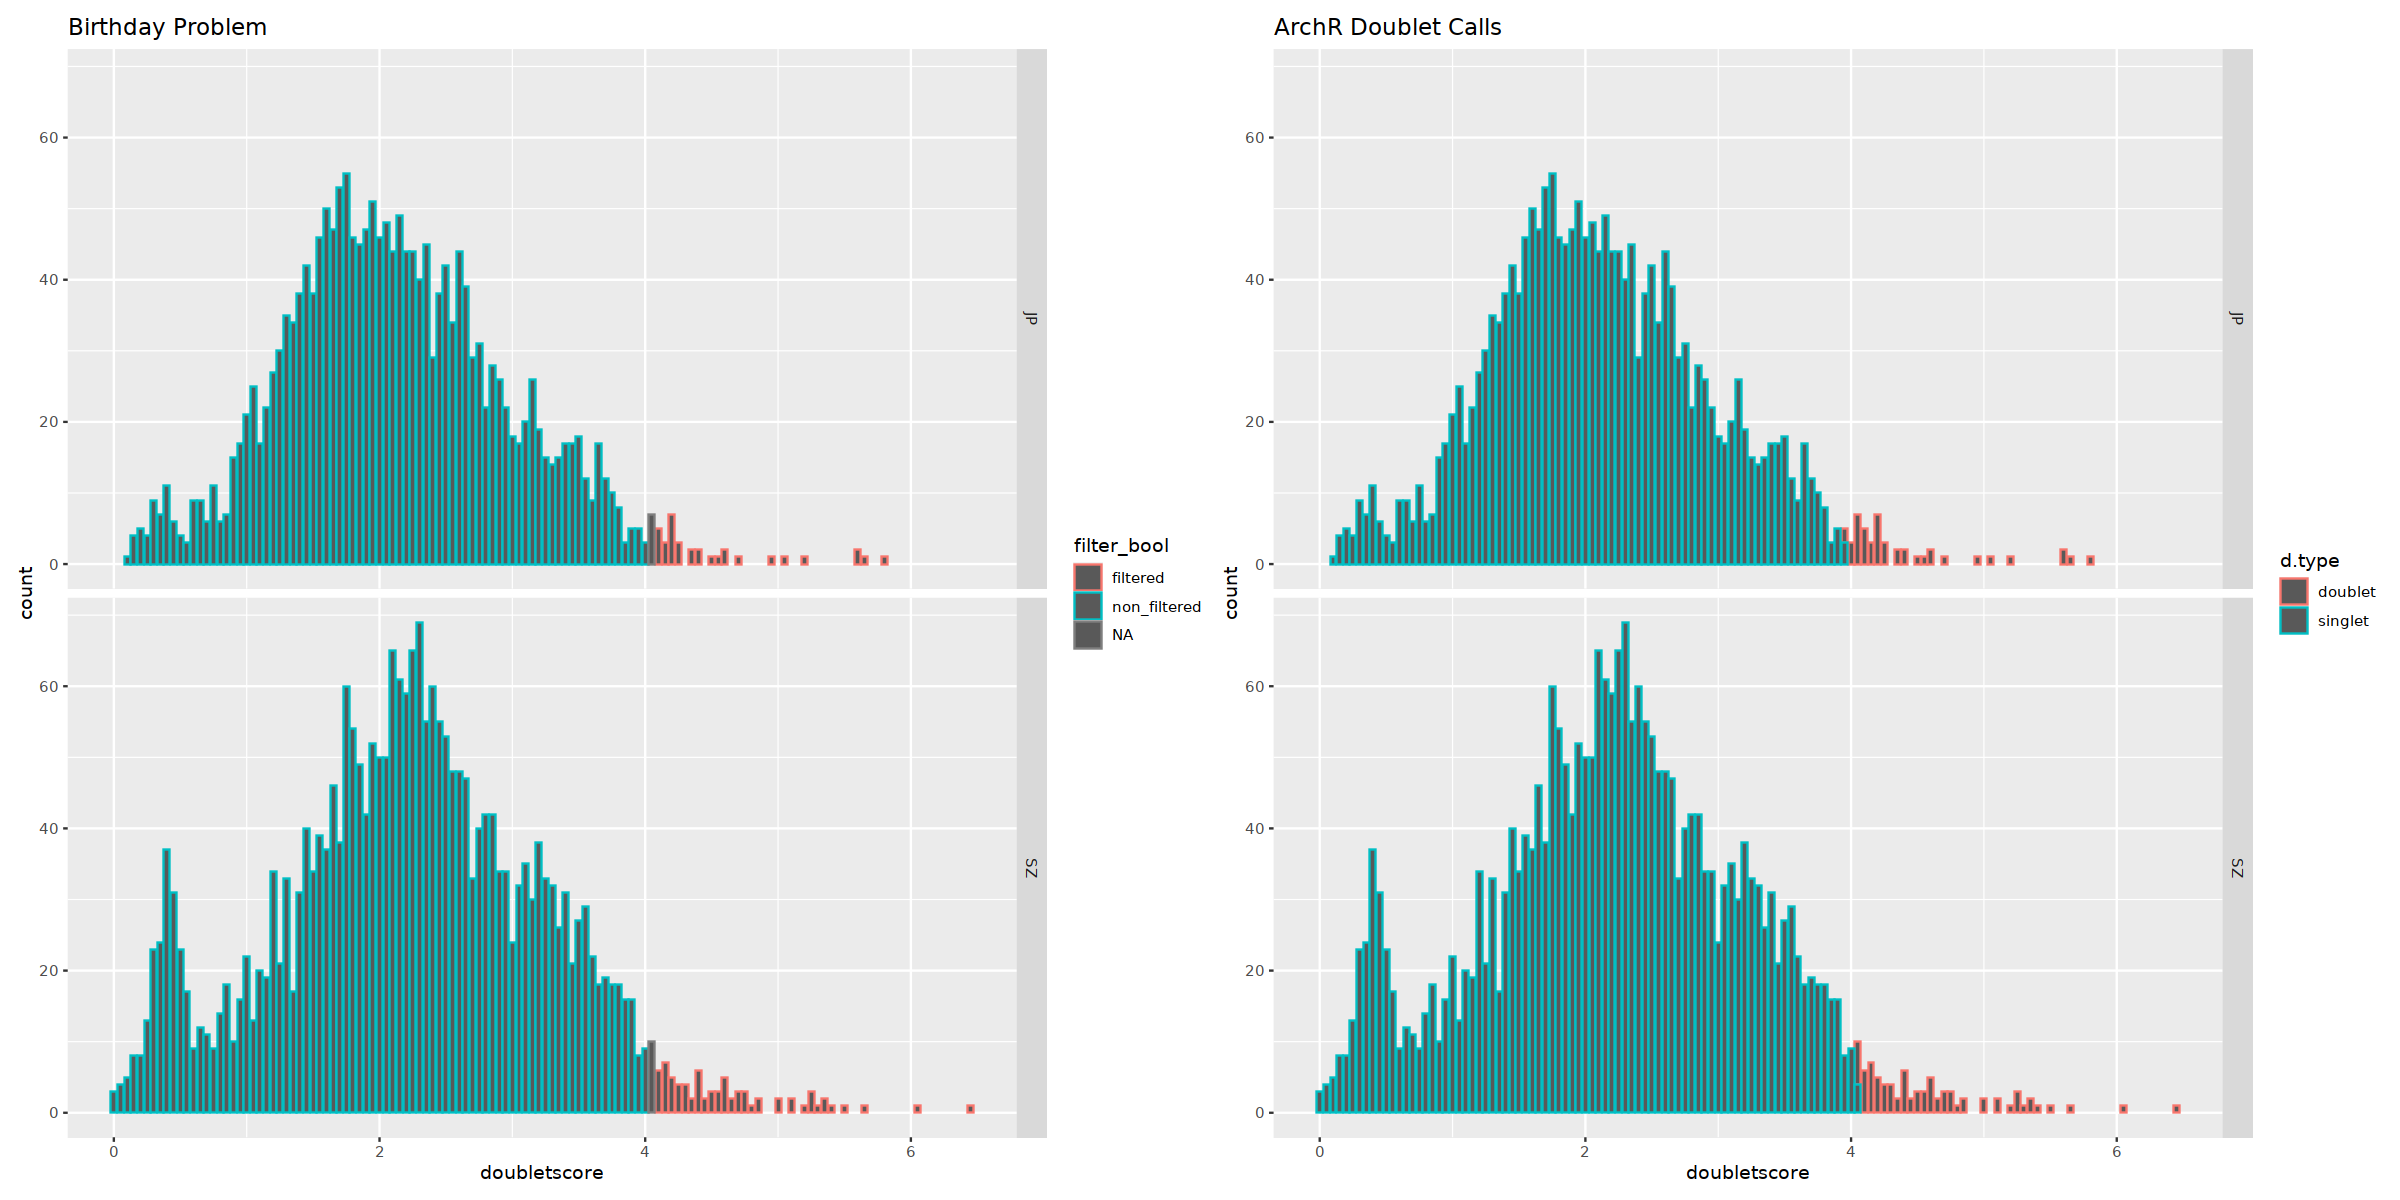

In [14]:
options(repr.plot.width=20, repr.plot.height=10)

birthday_problem_graph + archR_graph_1

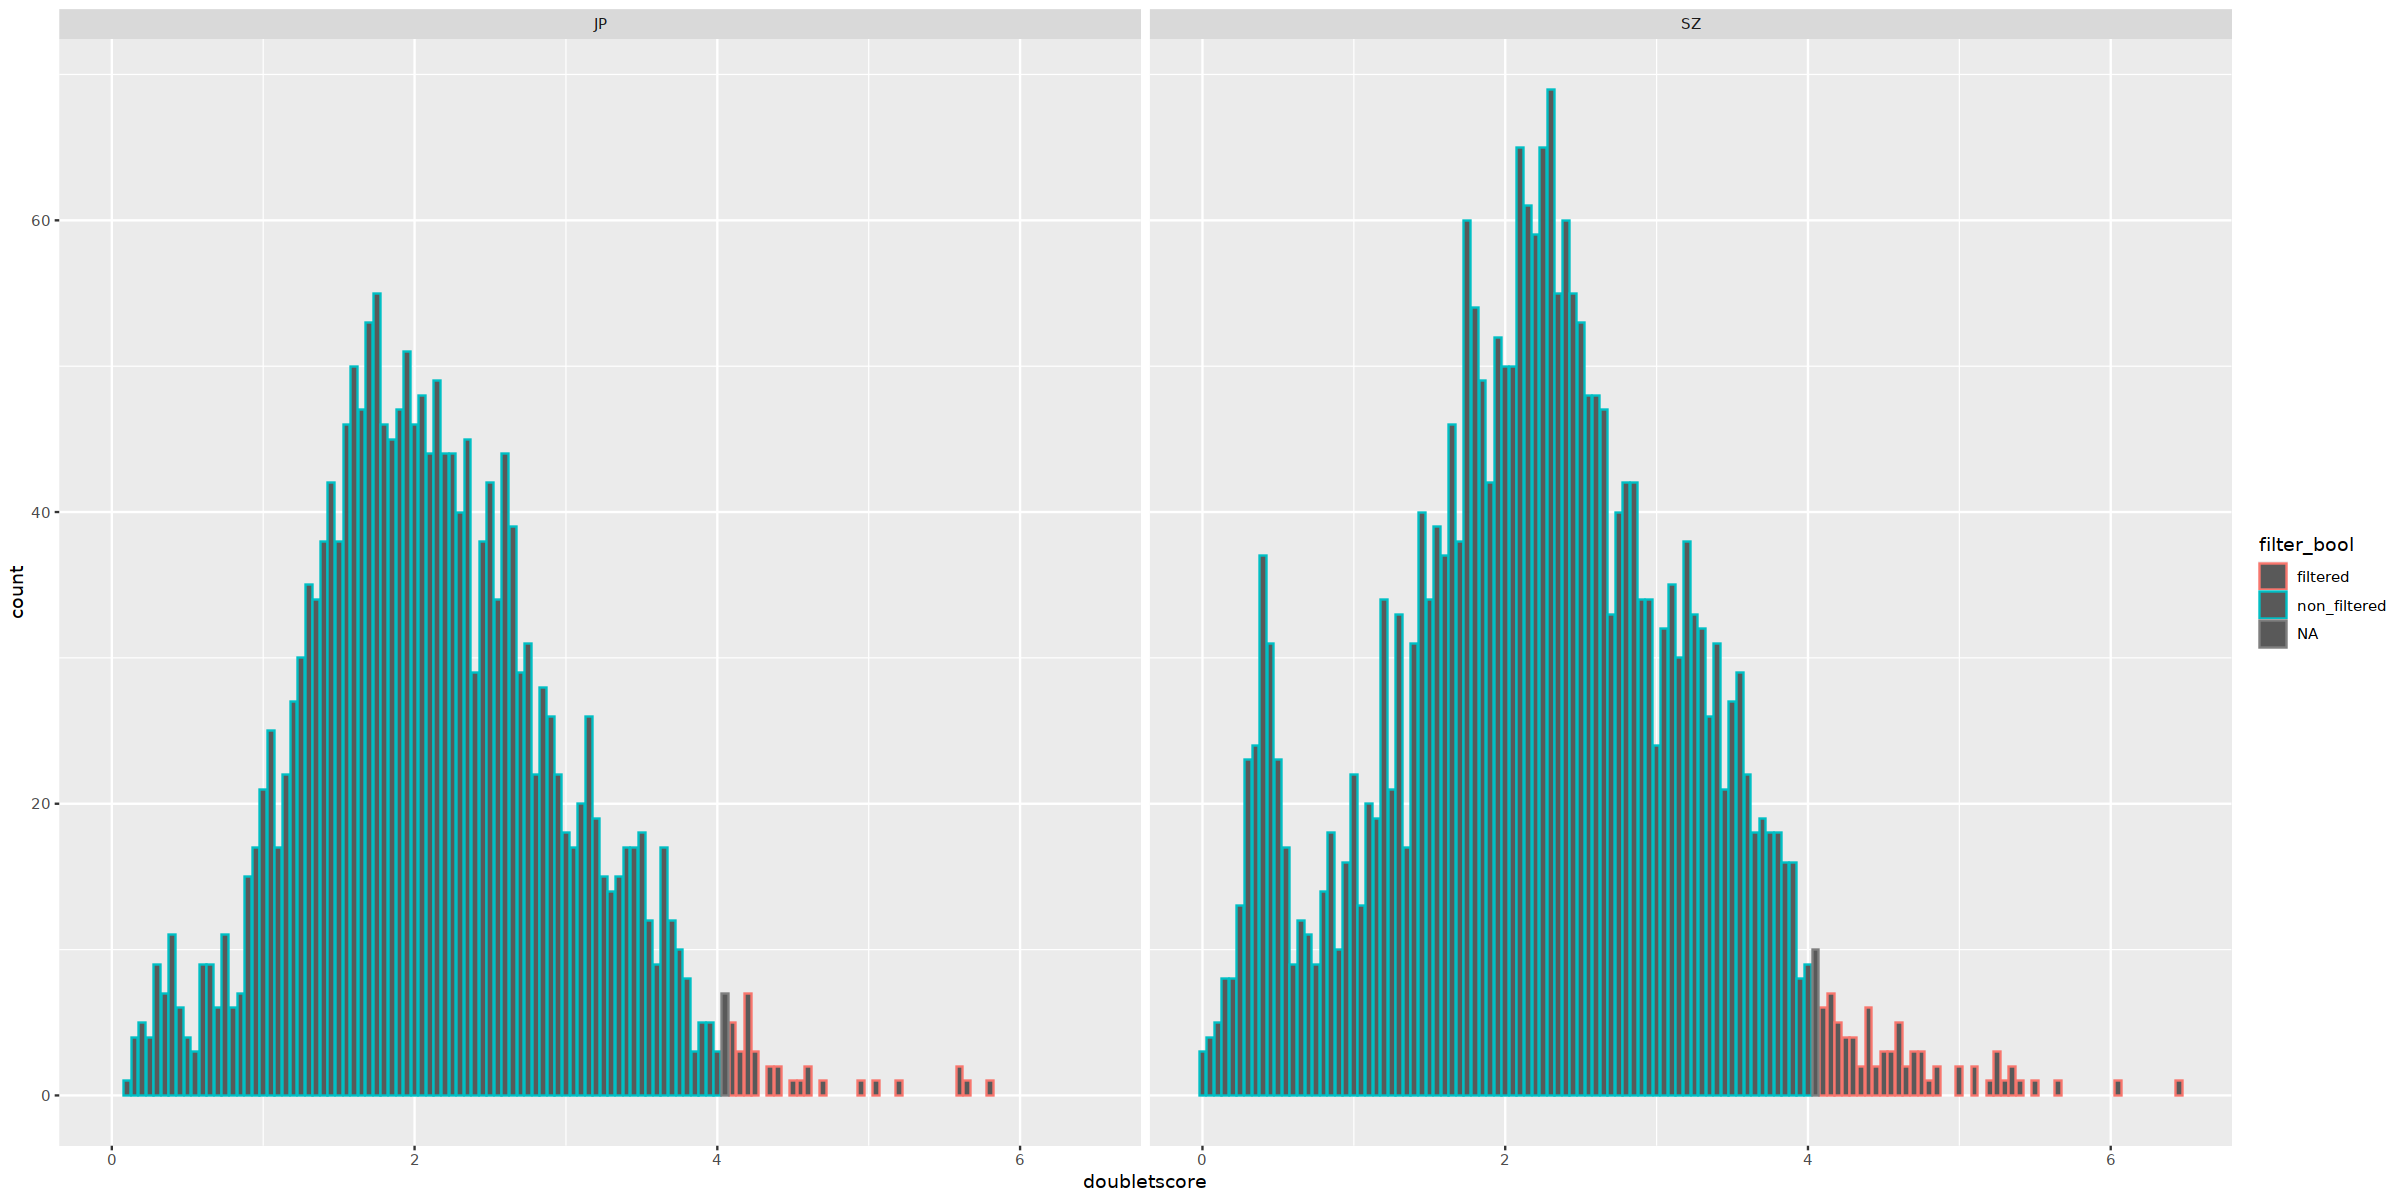

In [18]:
ggplot(birthday_problem, aes(doubletscore, color = filter_bool)) + 
geom_bar() + 
facet_grid(.~sampleID)

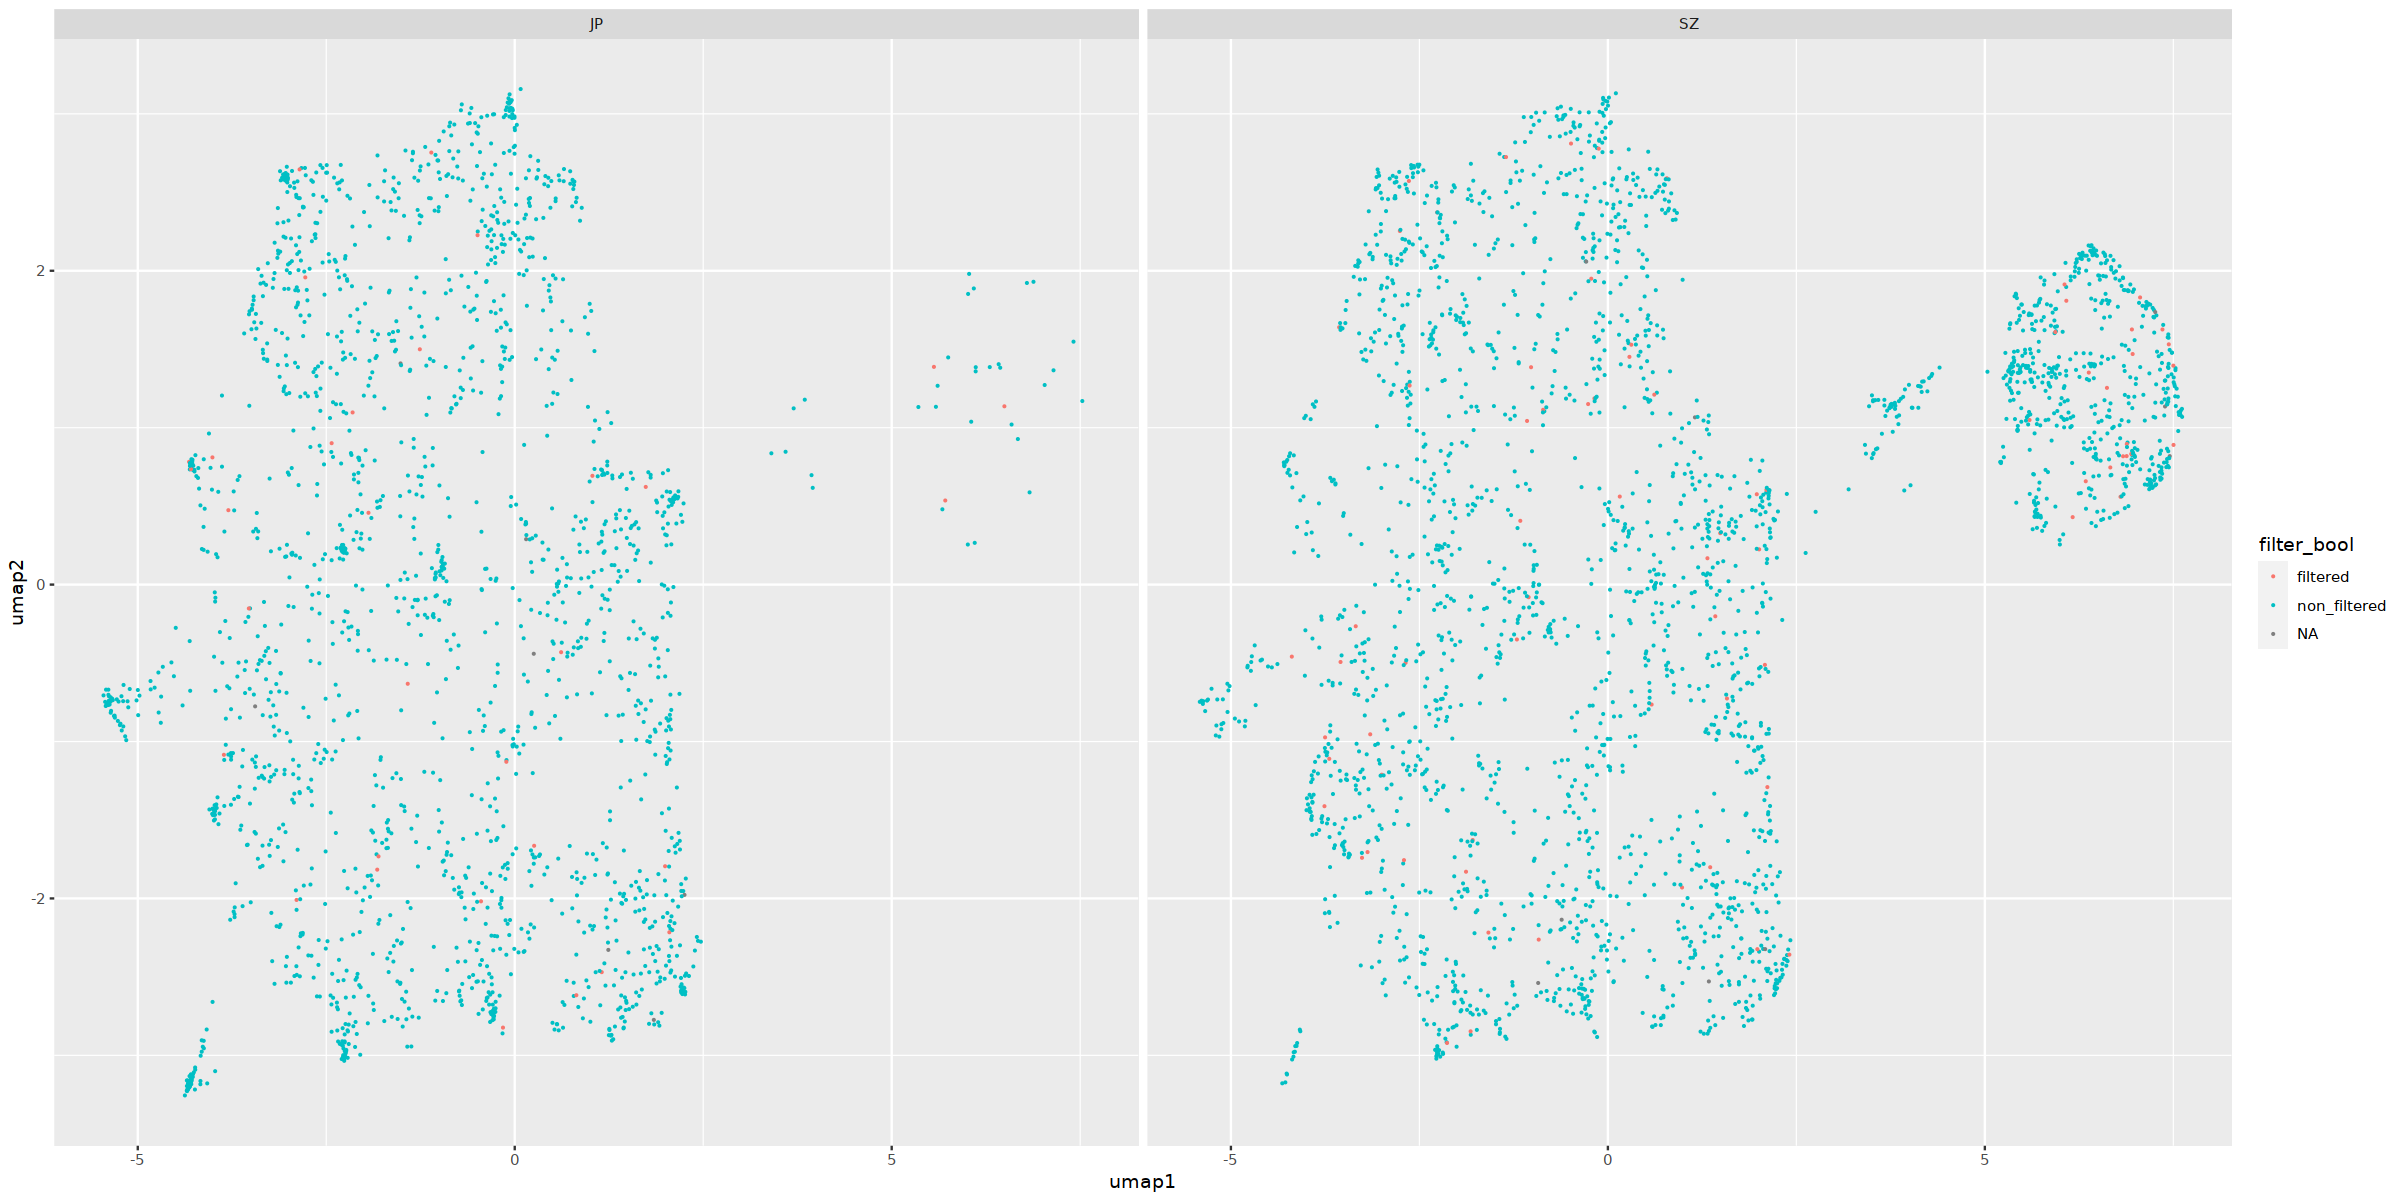

In [15]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(birthday_problem ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [19]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 647  Filtered: cells = 21515 | peaks = 163987



 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21144
Number of edges: 1115615

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.8224
Number of communities: 35
Elapsed time: 35 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 20930

 - filtering clusters with low cell/read counts ...



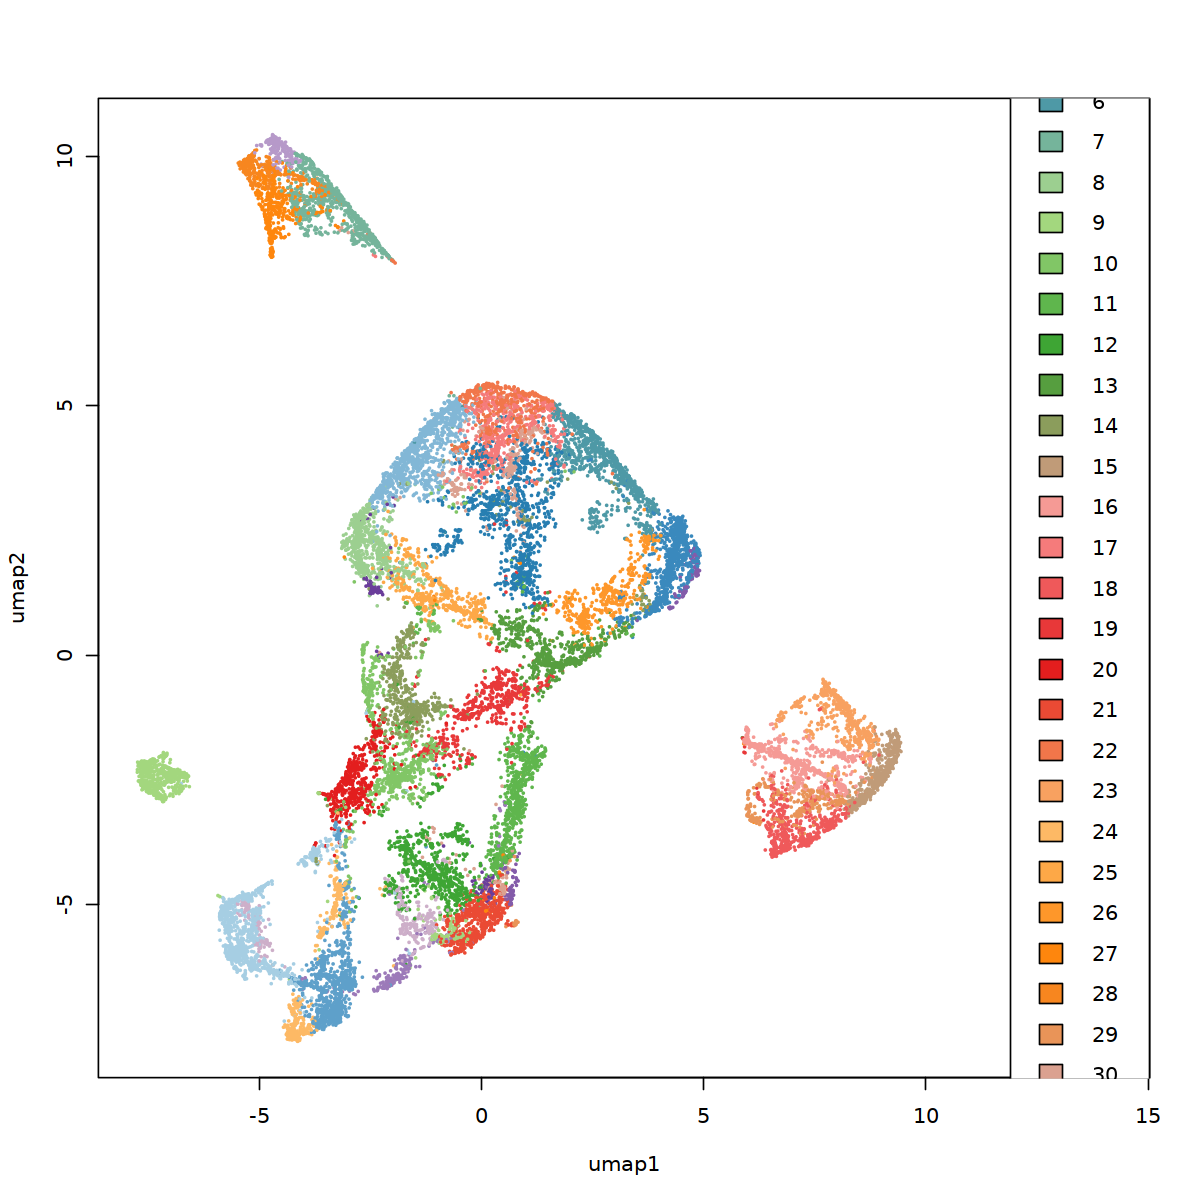

In [20]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2,
                        verbose=T,
                        svd_slotName= "NMF",
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()



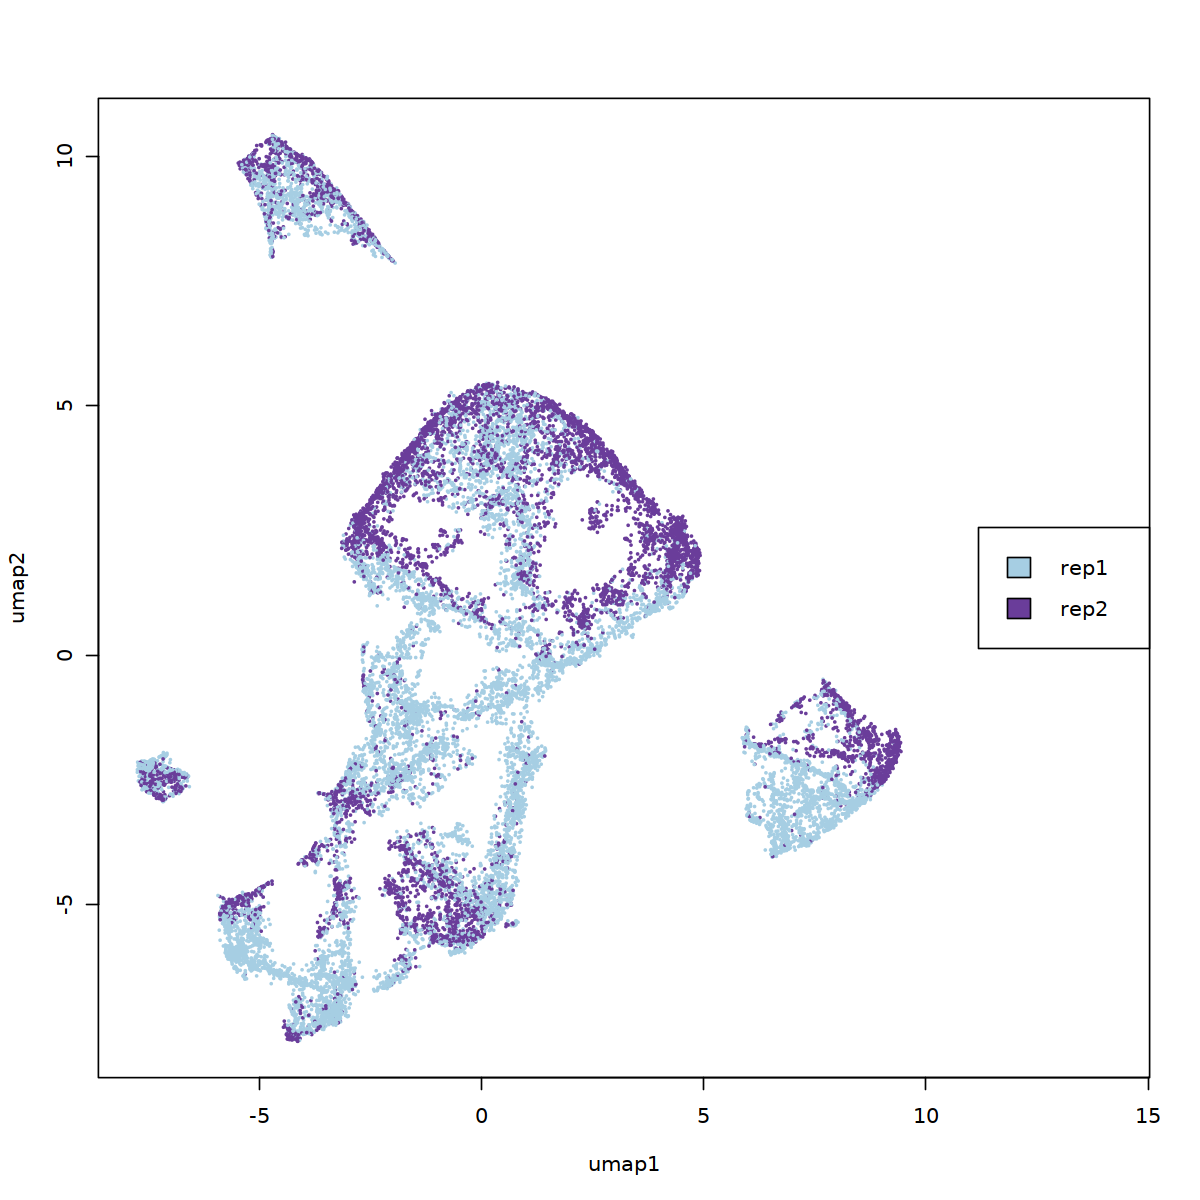

In [21]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

### Check Plate Integrations As well
If the replicates are so bad... Maybe some plates within the replicate are driving the issue?

In [44]:
library(tidyverse)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)
cell_converted_trible.df <- as.data.frame(cell_converted_trible)
colnames(cell_converted_trible)

[1] "cellID"          "barcode"         "plate"           "total"          
 [5] "tss"             "acrs"            "ptmt"            "nSites"         
 [9] "log10nSites"     "sampleID"        "umap1"           "umap2"          
[13] "doubletscore"    "d.type"          "LouvainClusters"

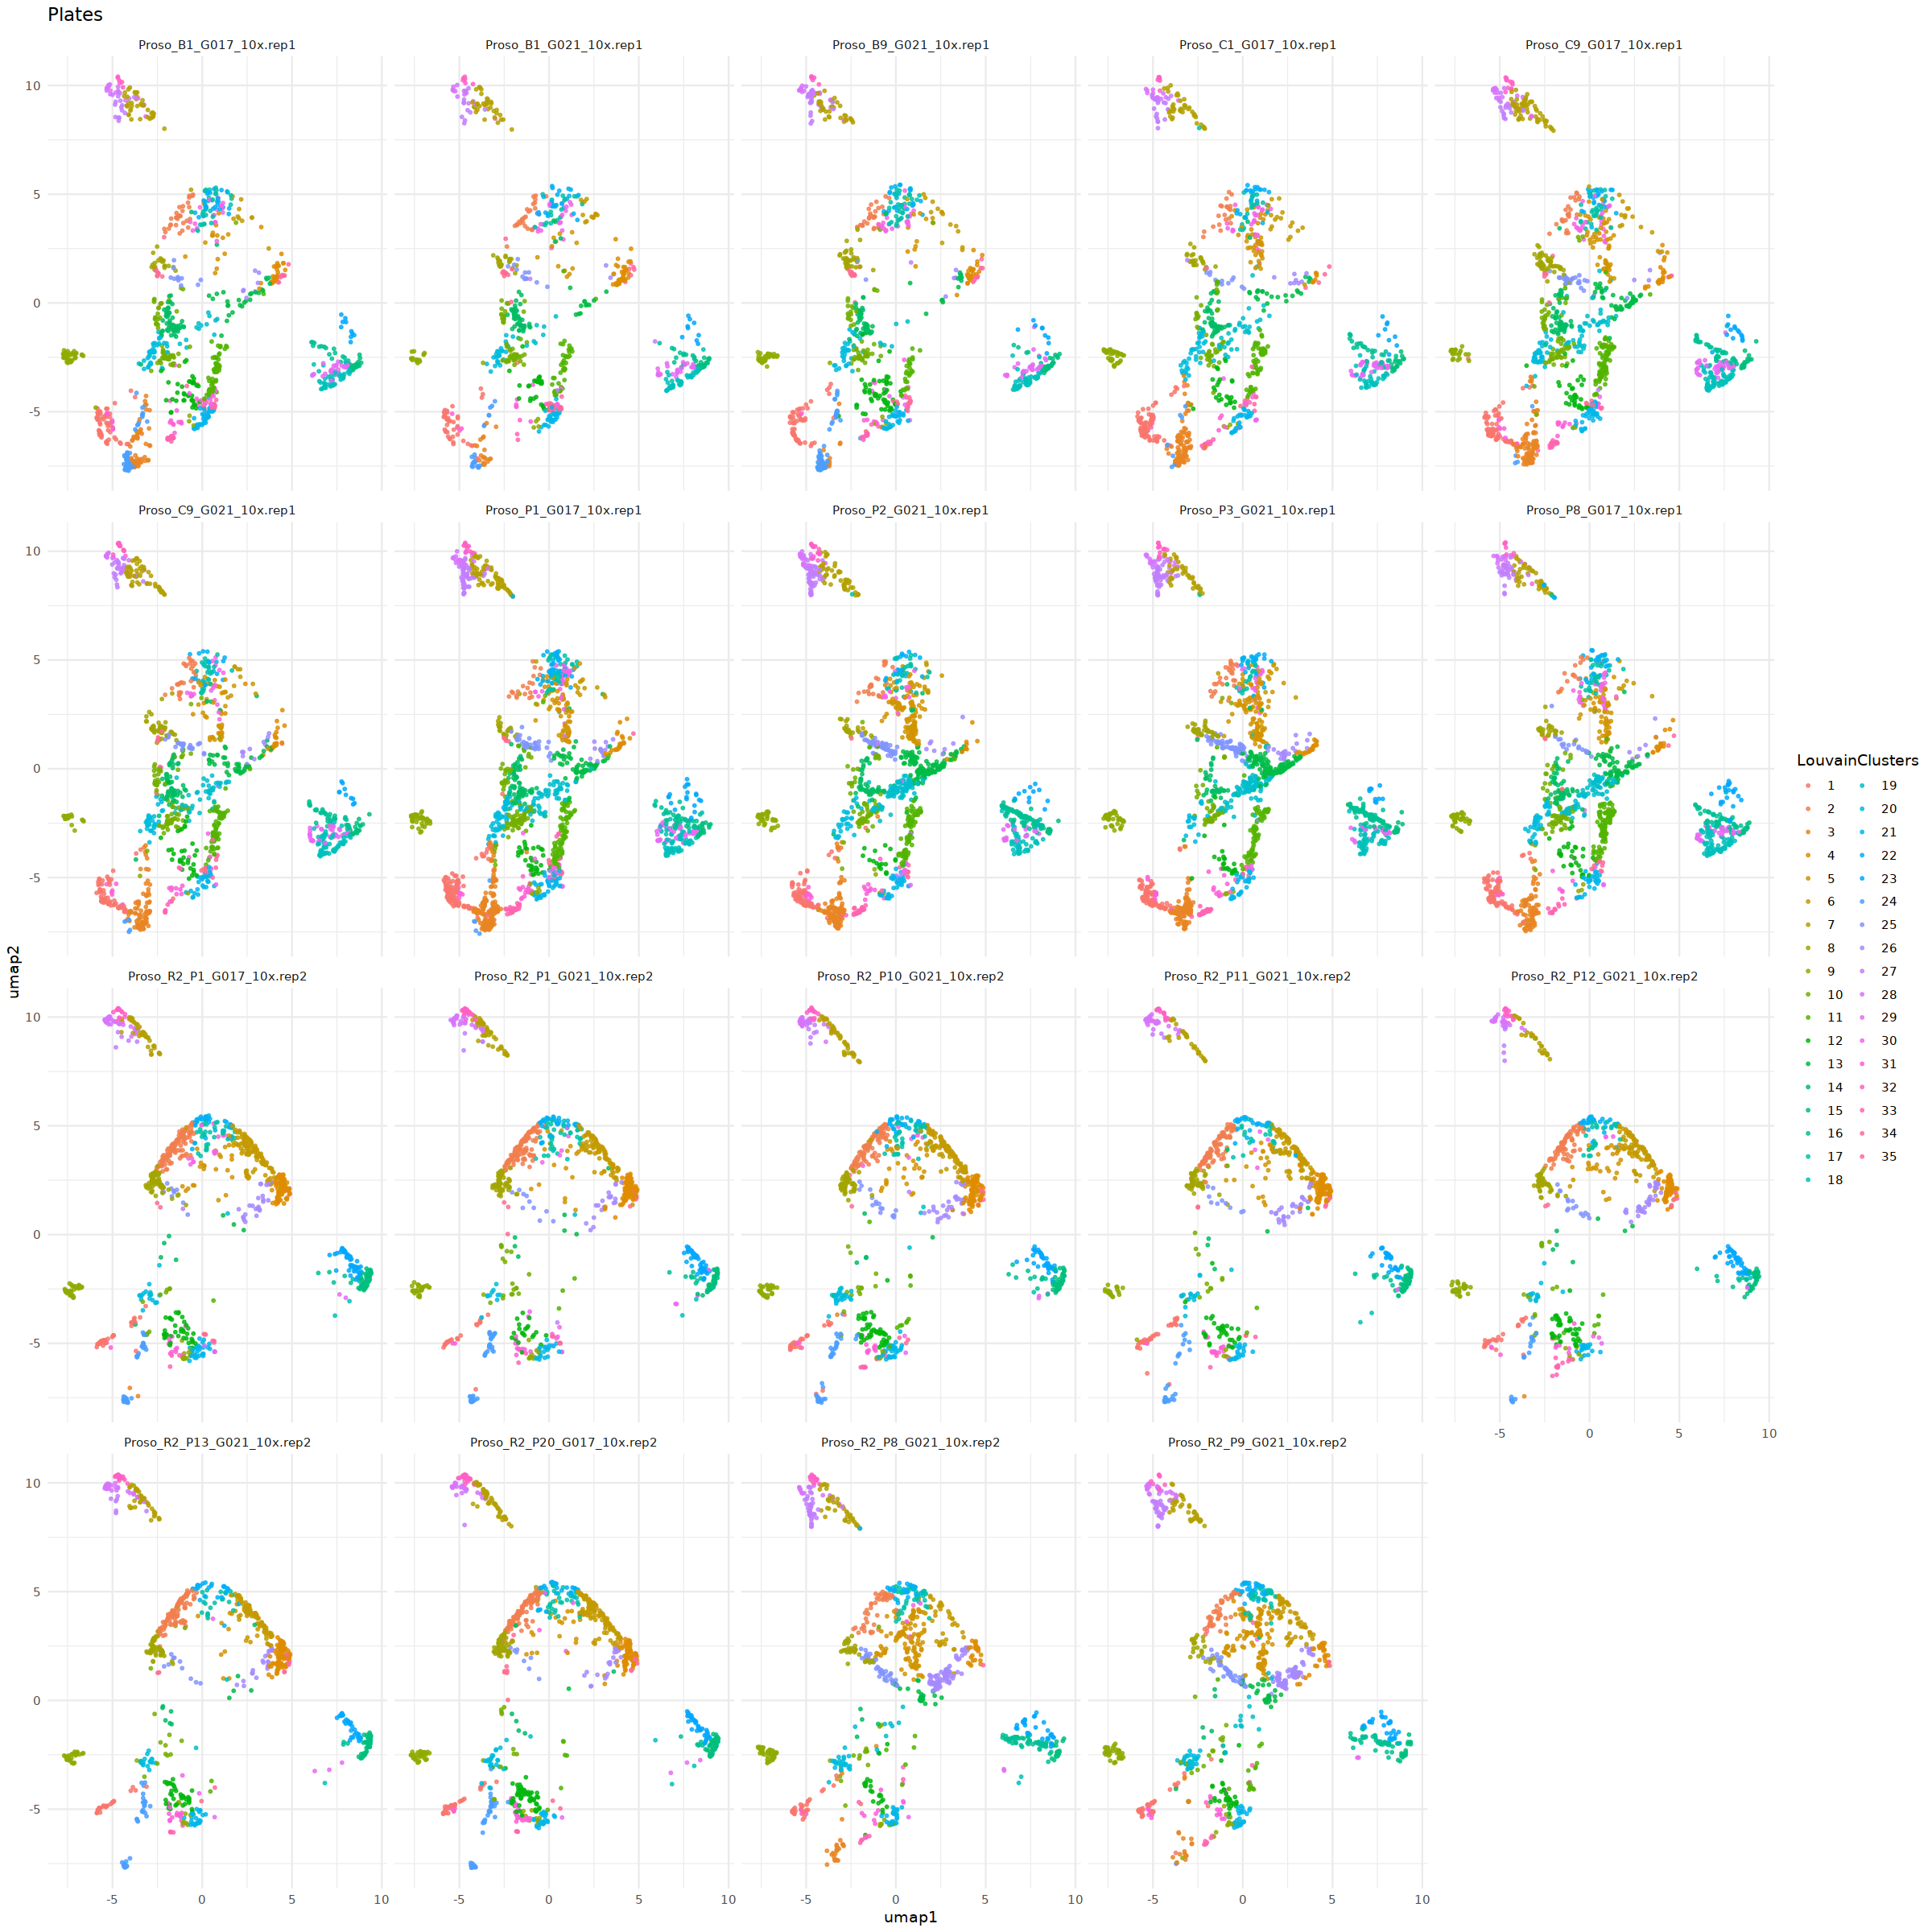

In [45]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(cell_converted_trible, aes(umap1, umap2, color = LouvainClusters)) + 
    geom_point(size = .6, alpha = .8) + theme_minimal() + ggtitle("Plates") +
    facet_wrap(~plate)

### Integration Looks Quite Poor even with NMF. 
Going to use harmony in order to improve overlap between the two datasets.

In [39]:
str(tfidf.obj.dob.filt.clusters$Clusters)

'data.frame':	20930 obs. of  13 variables:
 $ cellID         : chr  "BC:Z:CGATGTAGTCAACTAAGATGAGCACTAA-Proso_C1_G017_10x.rep1" "BC:Z:CGATGTGATCAGTCGCGGTTTCGCGAGG-Proso_C1_G017_10x.rep1" "BC:Z:TTAGGCTAGCTTCAATTATGAGCAACAT-Proso_C9_G017_10x.rep1" "BC:Z:TGACCACCGTCCCATCTACTGATAACAT-Proso_P1_G017_10x.rep1" ...
 $ total          : num  120154 94162 90645 85691 77960 ...
 $ tss            : num  50584 39140 37596 35974 32408 ...
 $ acrs           : num  96676 76176 74160 68481 63879 ...
 $ ptmt           : num  NA NA NA NA NA NA NA NA NA NA ...
 $ nSites         : num  52496 43924 40448 39936 35982 ...
 $ log10nSites    : num  4.72 4.64 4.61 4.6 4.56 ...
 $ sampleID       : chr  "rep1" "rep1" "rep1" "rep1" ...
 $ umap1          : num  6.68 7.79 -1.61 -7.08 -1.52 ...
 $ umap2          : num  -2.737 -0.622 1.633 -1.959 1.57 ...
 $ doubletscore   : num  0.568 0.409 0.159 0.477 0.25 ...
 $ d.type         : chr  "singlet" "singlet" "singlet" "singlet" ...
 $ LouvainClusters: Factor w/ 35 levels "

In [108]:
saved_cells <- tfidf.obj.dob.filt.clusters$Clusters$cellID
NMFs <- tfidf.obj.dob.filt.clusters$NMF
saved_NMFs <- NMFs[saved_cells, ]
dim(saved_NMFs)

[1] 20930    15

In [117]:
set.seed(1)
harmonized_pcs <- HarmonyMatrix(
  data_mat  = saved_NMFs,       # Matrix with coordinates for each cell (row) along many PCs (columns)
  meta_data = cell_converted_trible.df, # Dataframe with information for each cell (row)
  vars_use  = c("sampleID","plate"),
  verbose=TRUE, 
  theta = c(8,4), ## cluster diversity enforcement
  nclust = 5, ## number of clusters in Harmony model  
  do_pca = FALSE      # Since we are providing PCs, do not run PCA
)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations



In [118]:
tfidf.obj.dob.filt.replace_NMF <- tfidf.obj.dob.filt.clusters
tfidf.obj.dob.filt.replace_NMF$NMF <- harmonized_pcs


soc.obj.project_umap.NMF <- projectUMAP(tfidf.obj.dob.filt.replace_NMF, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="NMF")

# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.replace_NMF.clusters <- callClusters(soc.obj.project_umap.NMF, 
                        res=2,
                        verbose=T,
                        svd_slotName= "NMF",
                        cleanCluster=TRUE)

 - non-linear dimensionality reduction with UMAP ...

14:53:56 UMAP embedding parameters a = 1.896 b = 0.8006

14:53:56 Read 20930 rows and found 15 numeric columns

14:53:56 Using Annoy for neighbor search, n_neighbors = 25

14:53:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:53:58 Writing NN index file to temp file /tmp/RtmpqCbl5n/file35b15c0a5c1d

14:53:58 Searching Annoy index using 16 threads, search_k = 2500

14:53:58 Annoy recall = 100%

14:54:01 Commencing smooth kNN distance calibration using 16 threads

14:54:04 Initializing from normalized Laplacian + noise

14:54:05 Commencing optimization for 200 epochs, with 732678 positive edges

14:54:29 Optimization finished

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 20589
Number of edges: 1094949

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.8250
Number of communities: 36
Elapsed time: 30 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 20445

 - filtering clusters with low cell/read counts ...



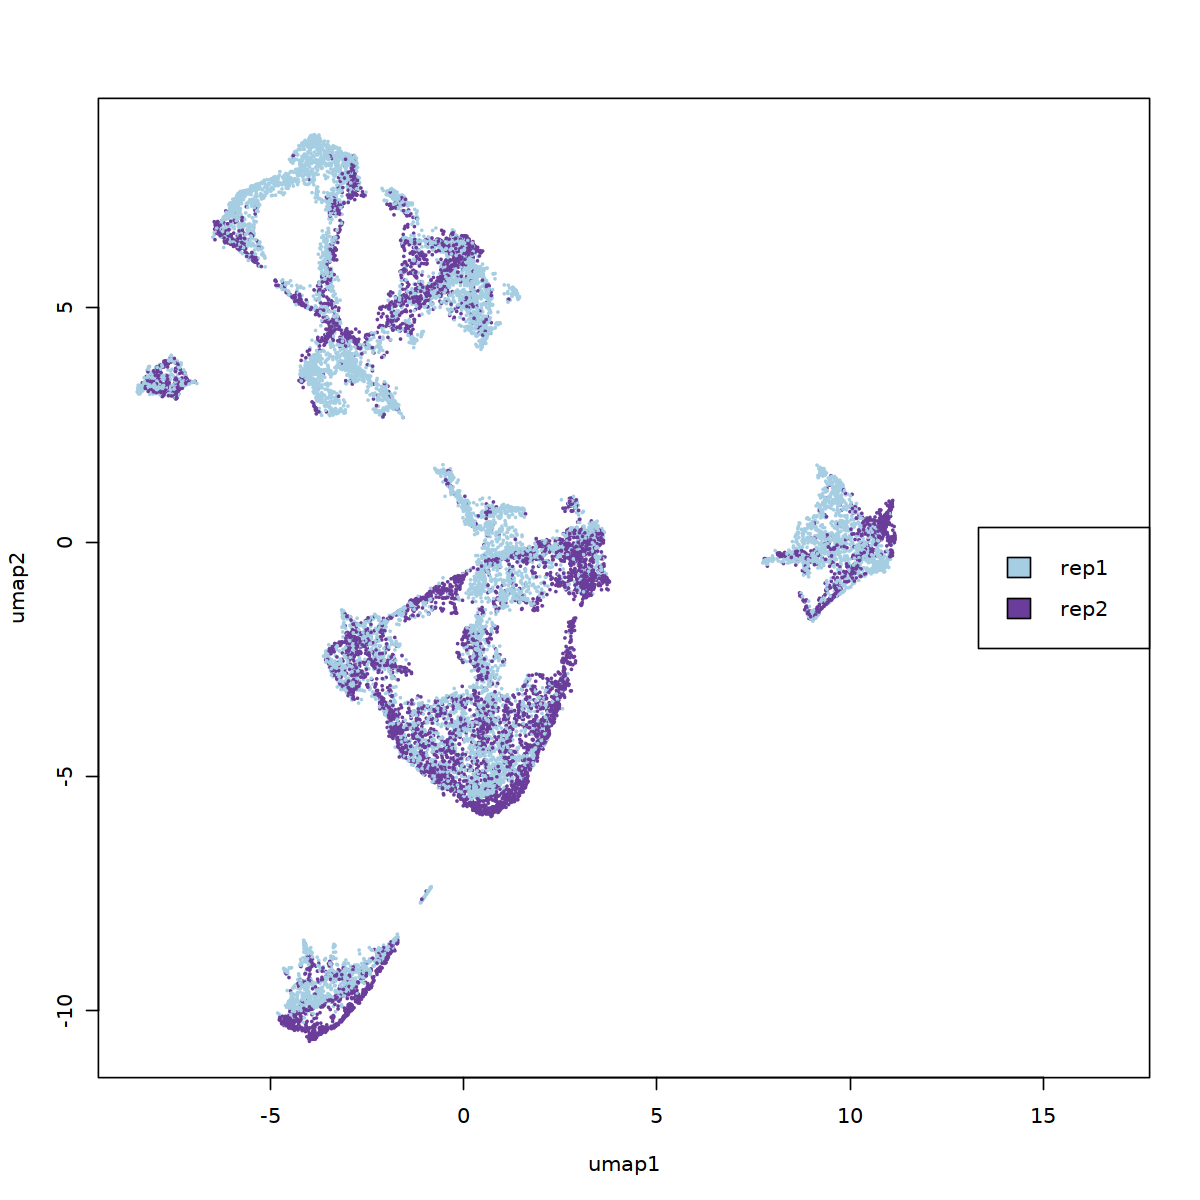

In [119]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
plotUMAP(tfidf.obj.dob.filt.replace_NMF.clusters, cex=0.3, column = "sampleID")

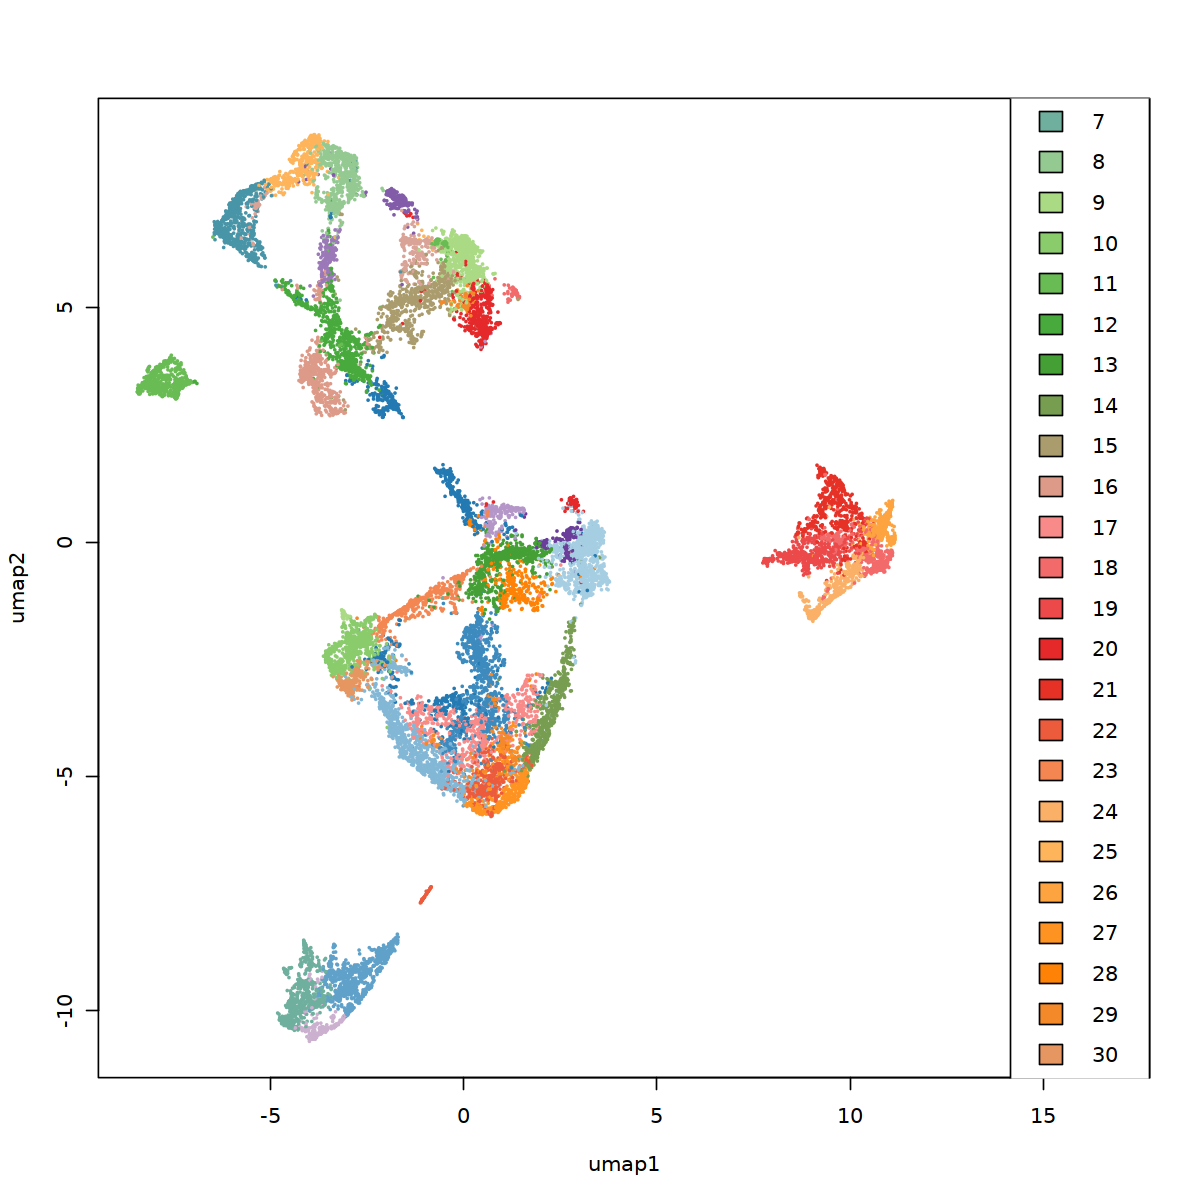

In [120]:
plotUMAP(tfidf.obj.dob.filt.replace_NMF.clusters, cex=0.3)

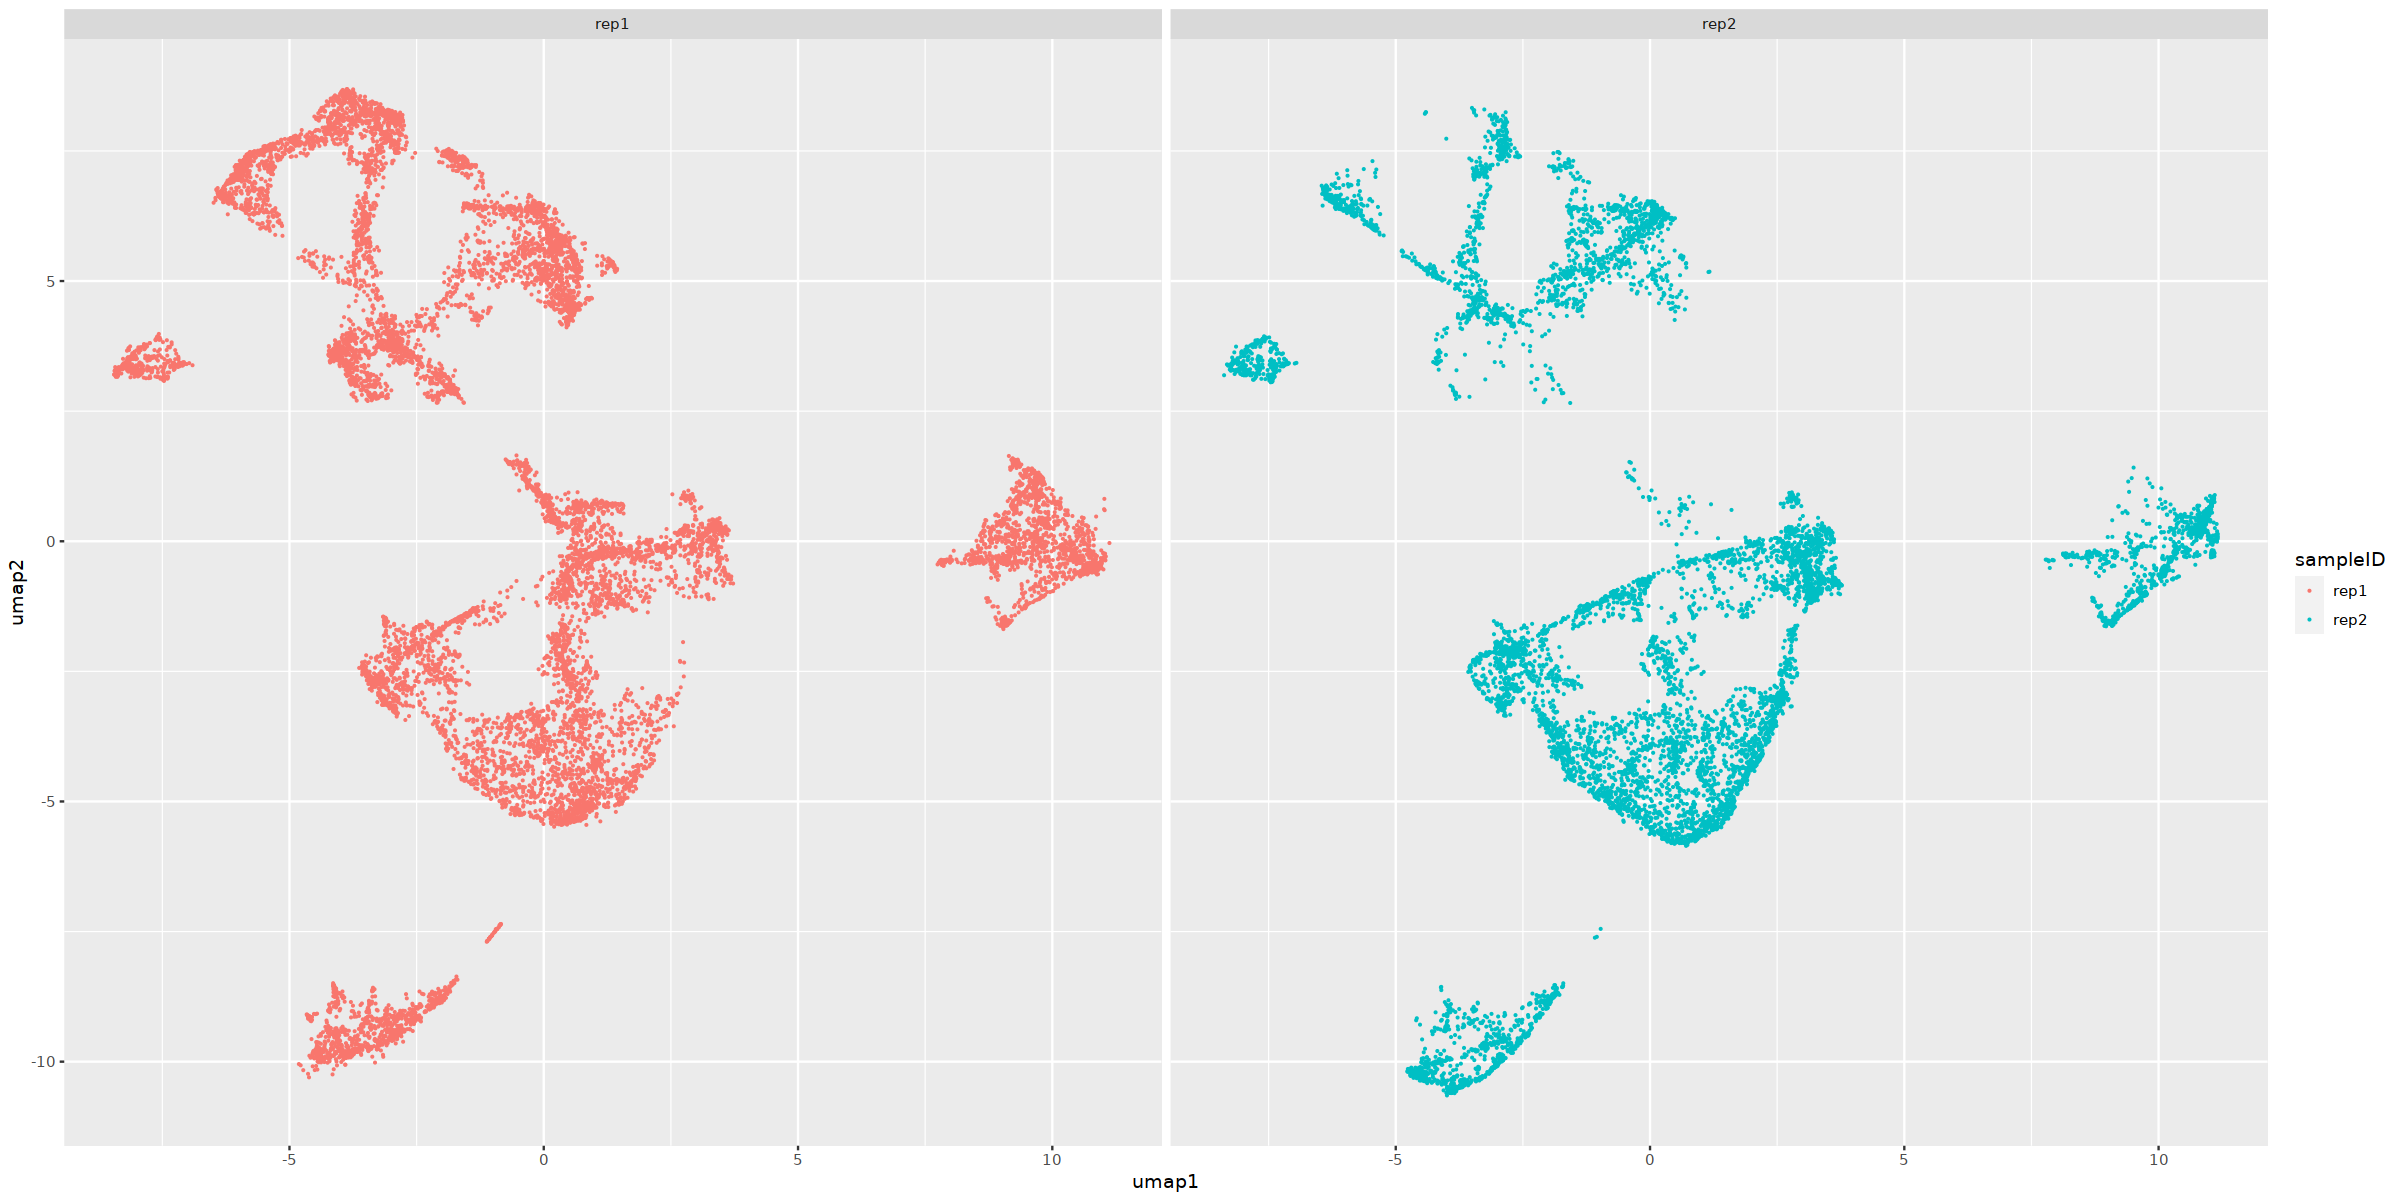

In [124]:
options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(tfidf.obj.dob.filt.replace_NMF.clusters$Clusters)

ggplot(cluster_plot ,aes(umap1, umap2, color = sampleID)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [128]:
saved_cells <- tfidf.obj.dob.filt.replace_NMF.clusters$Clusters$cellID
NMFs_v2 <- tfidf.obj.dob.filt.replace_NMF.clusters$NMF
saved_NMFs <- NMFs[saved_cells, ]
dim(saved_NMFs)

set.seed(1)
harmonized_pcs_v2 <- HarmonyMatrix(
  data_mat  = NMFs_v2,       # Matrix with coordinates for each cell (row) along many PCs (columns)
  meta_data = cell_converted_trible.df, # Dataframe with information for each cell (row)
  vars_use  = c("sampleID"),
  verbose=TRUE, 
  do_pca = FALSE      # Since we are providing PCs, do not run PCA
)

[1] 20412    15

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



In [129]:
tfidf.obj.dob.filt.replace_NMF <- tfidf.obj.dob.filt.clusters
tfidf.obj.dob.filt.replace_NMF$NMF <- harmonized_pcs_v2


soc.obj.project_umap.NMF <- projectUMAP(tfidf.obj.dob.filt.replace_NMF, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="NMF")

# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.replace_NMF.clusters <- callClusters(soc.obj.project_umap.NMF, 
                        res=2,
                        verbose=T,
                        svd_slotName= "NMF",
                        cleanCluster=TRUE)

 - non-linear dimensionality reduction with UMAP ...

15:01:46 UMAP embedding parameters a = 1.896 b = 0.8006

15:01:46 Read 20930 rows and found 15 numeric columns

15:01:46 Using Annoy for neighbor search, n_neighbors = 25

15:01:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:01:48 Writing NN index file to temp file /tmp/RtmpqCbl5n/file35b153385a669

15:01:48 Searching Annoy index using 16 threads, search_k = 2500

15:01:49 Annoy recall = 100%

15:01:52 Commencing smooth kNN distance calibration using 16 threads

15:01:55 Initializing from normalized Laplacian + noise

15:01:55 Commencing optimization for 200 epochs, with 739134 positive edges

15:02:20 Optimization finished

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 20674
Number of edges: 1120884

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.8271
Number of communities: 37
Elapsed time: 35 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 20504

 - filtering clusters with low cell/read counts ...



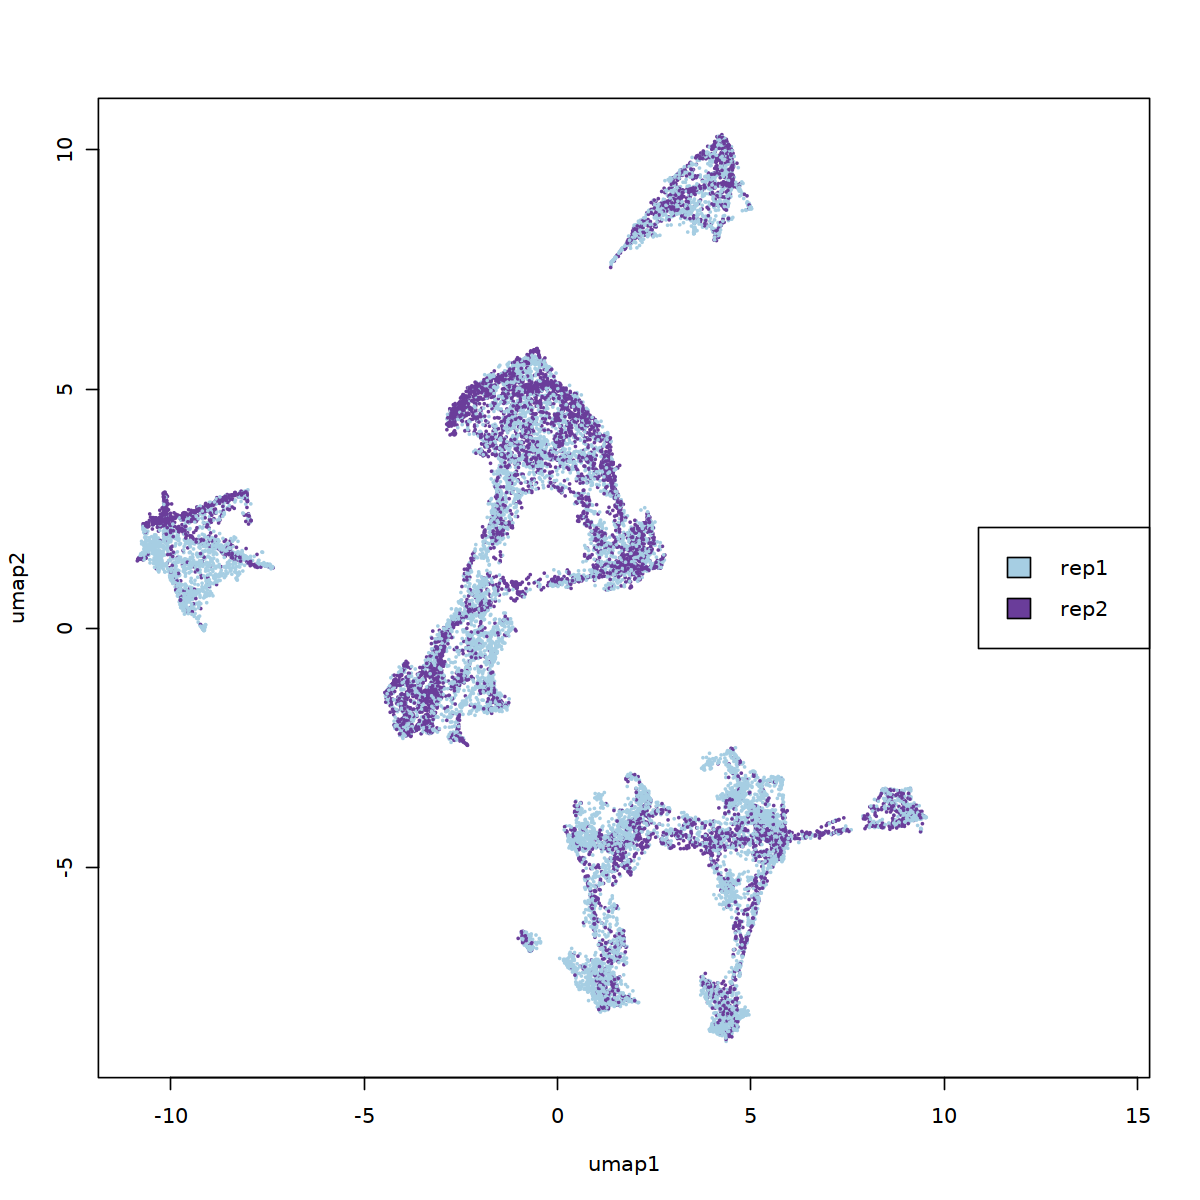

In [130]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
plotUMAP(tfidf.obj.dob.filt.replace_NMF.clusters, cex=0.3, column = "sampleID")

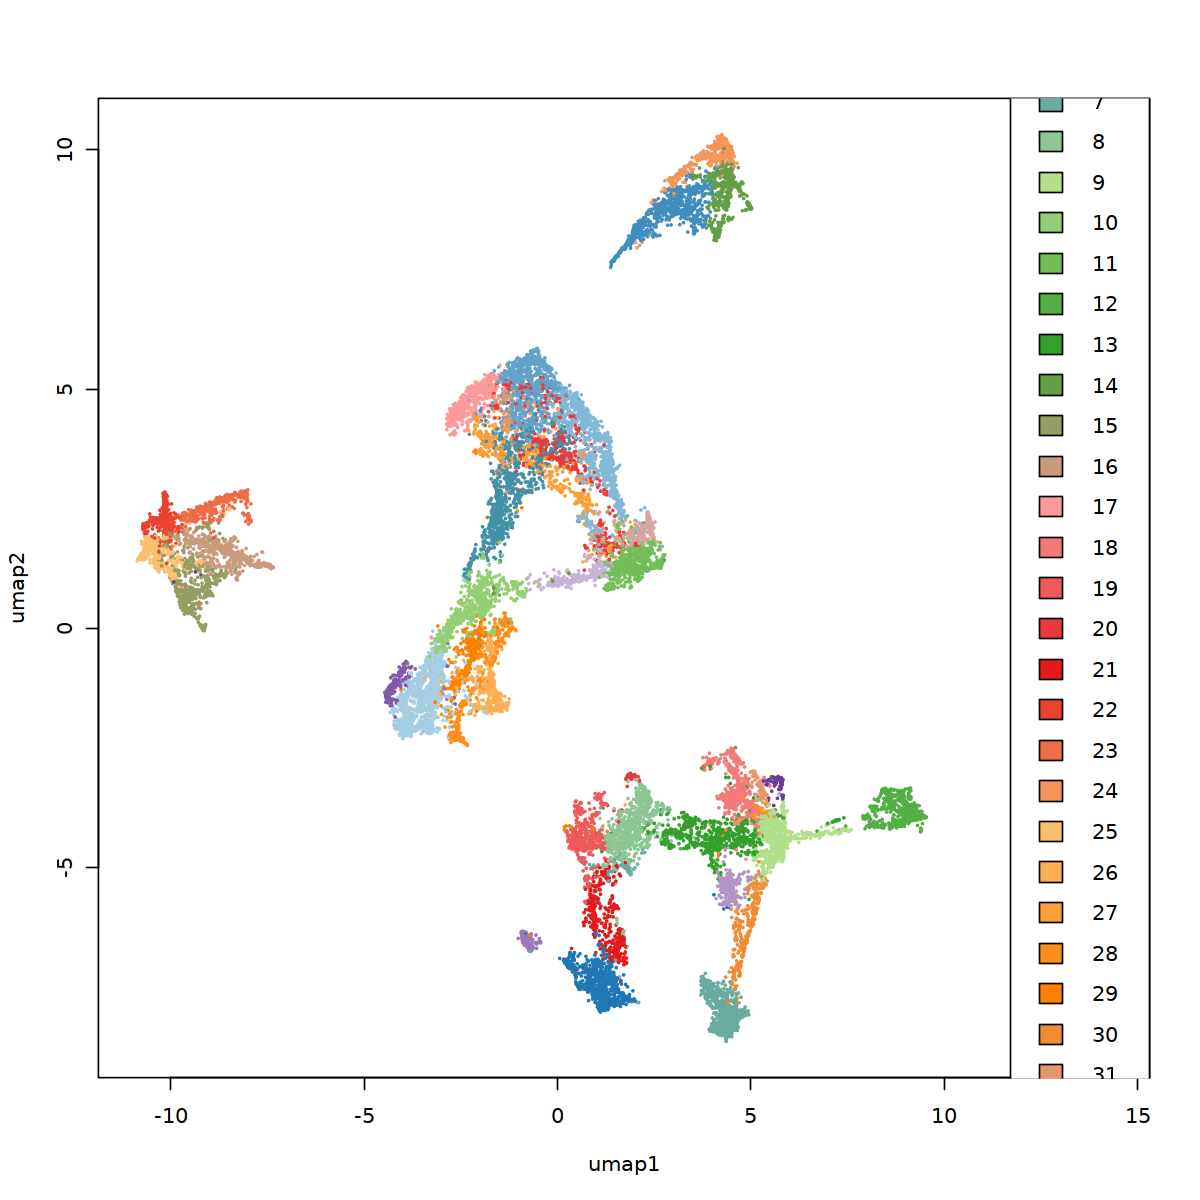

In [131]:
plotUMAP(tfidf.obj.dob.filt.replace_NMF.clusters, cex=0.3)

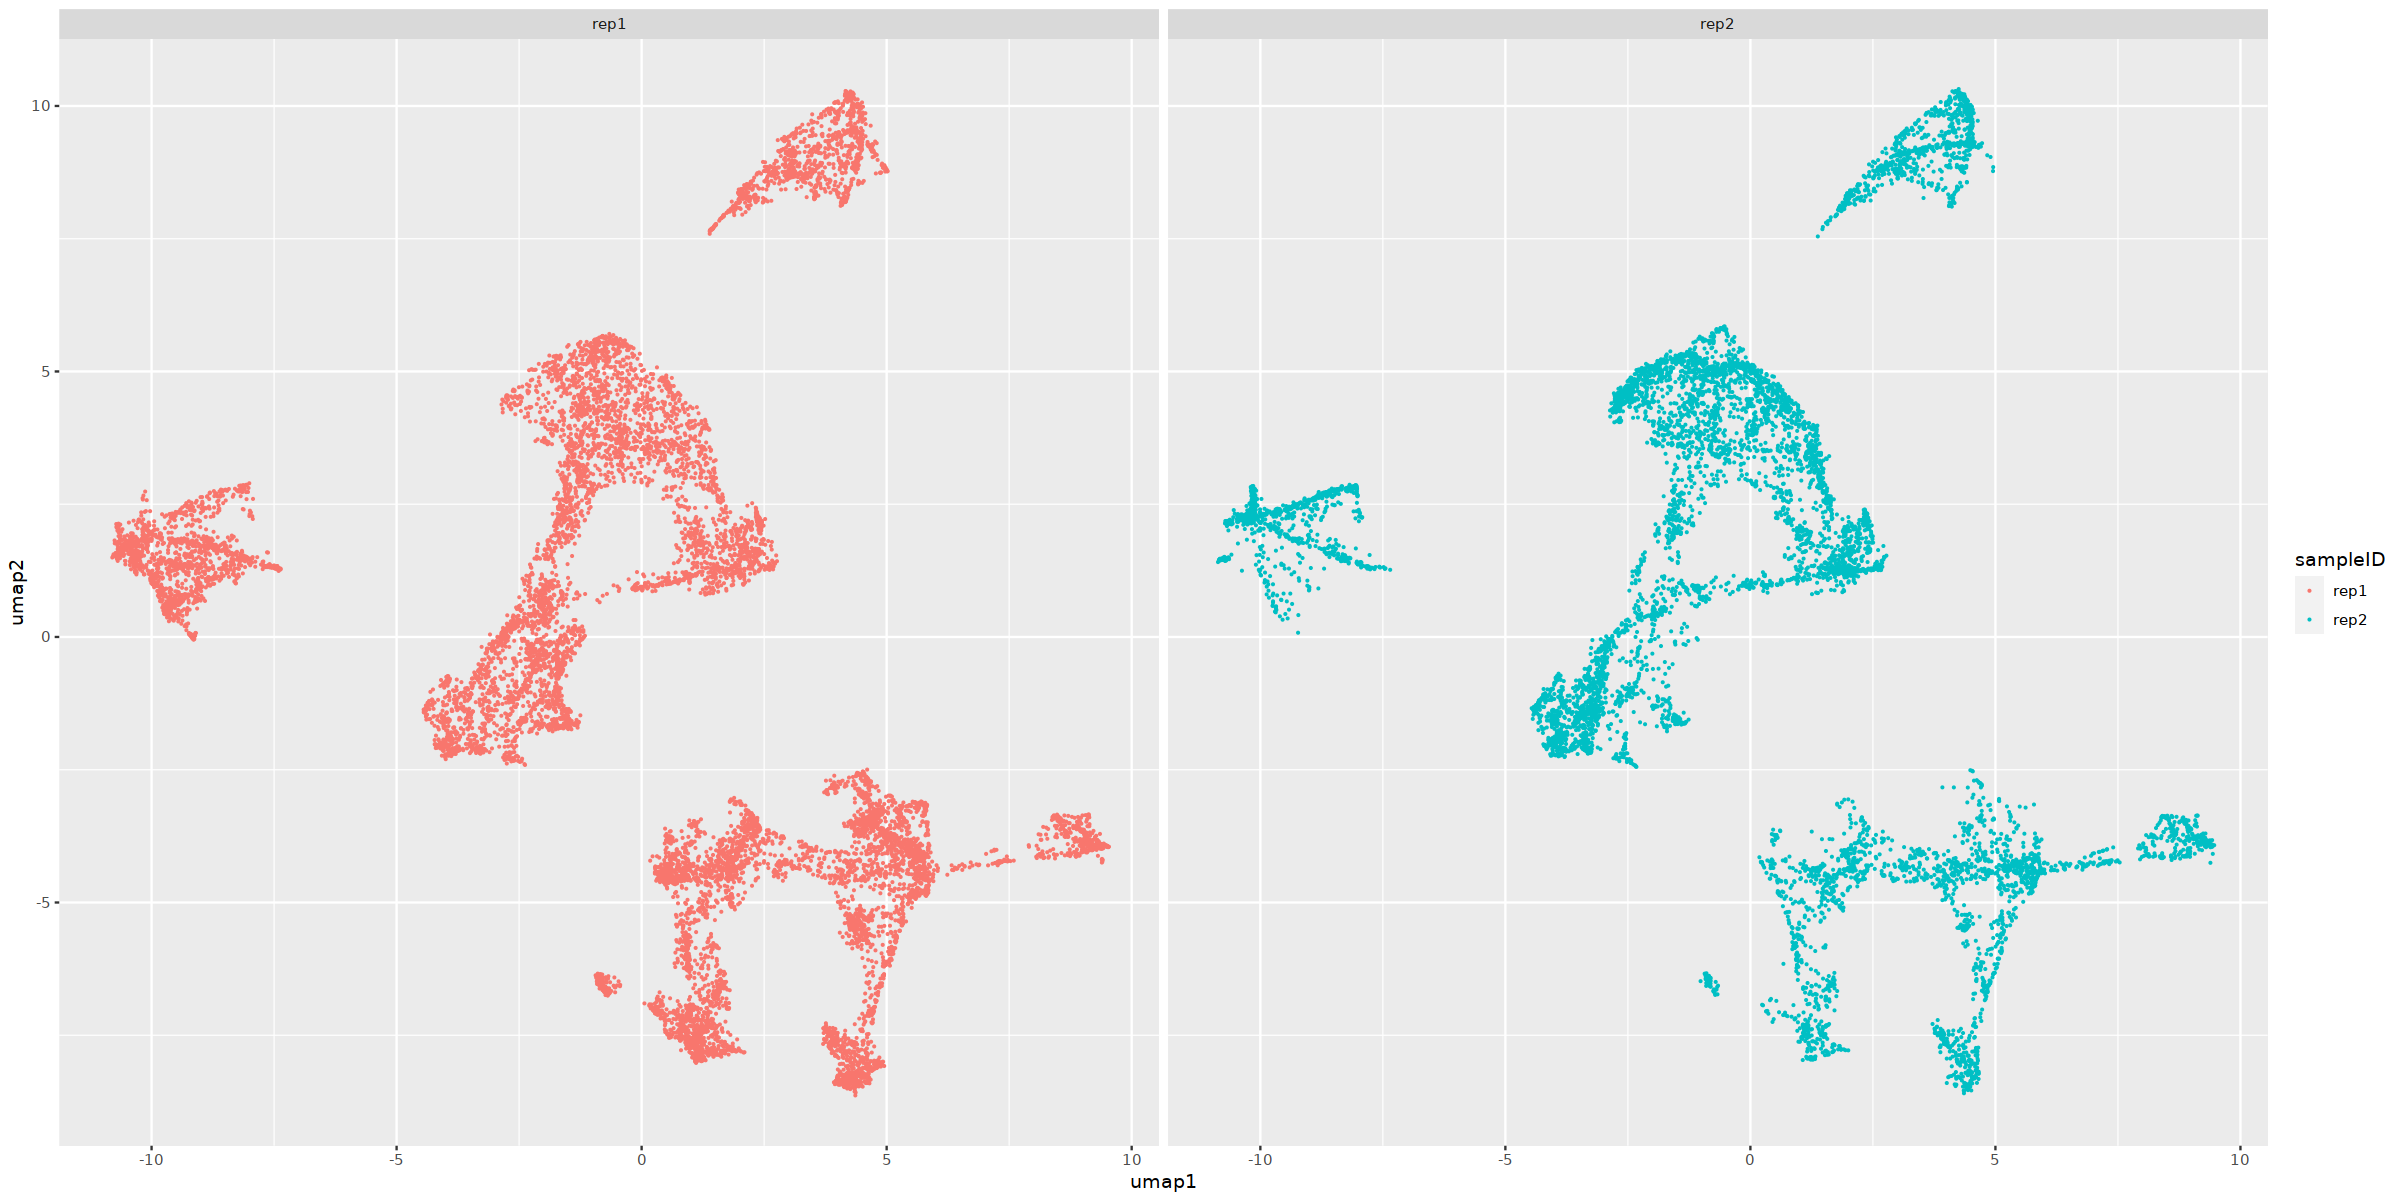

In [132]:
options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(tfidf.obj.dob.filt.replace_NMF.clusters$Clusters)

ggplot(cluster_plot ,aes(umap1, umap2, color = sampleID)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

[1] "cellID"          "barcode"         "plate"           "total"          
 [5] "tss"             "acrs"            "ptmt"            "nSites"         
 [9] "log10nSites"     "sampleID"        "umap1"           "umap2"          
[13] "doubletscore"    "d.type"          "LouvainClusters"

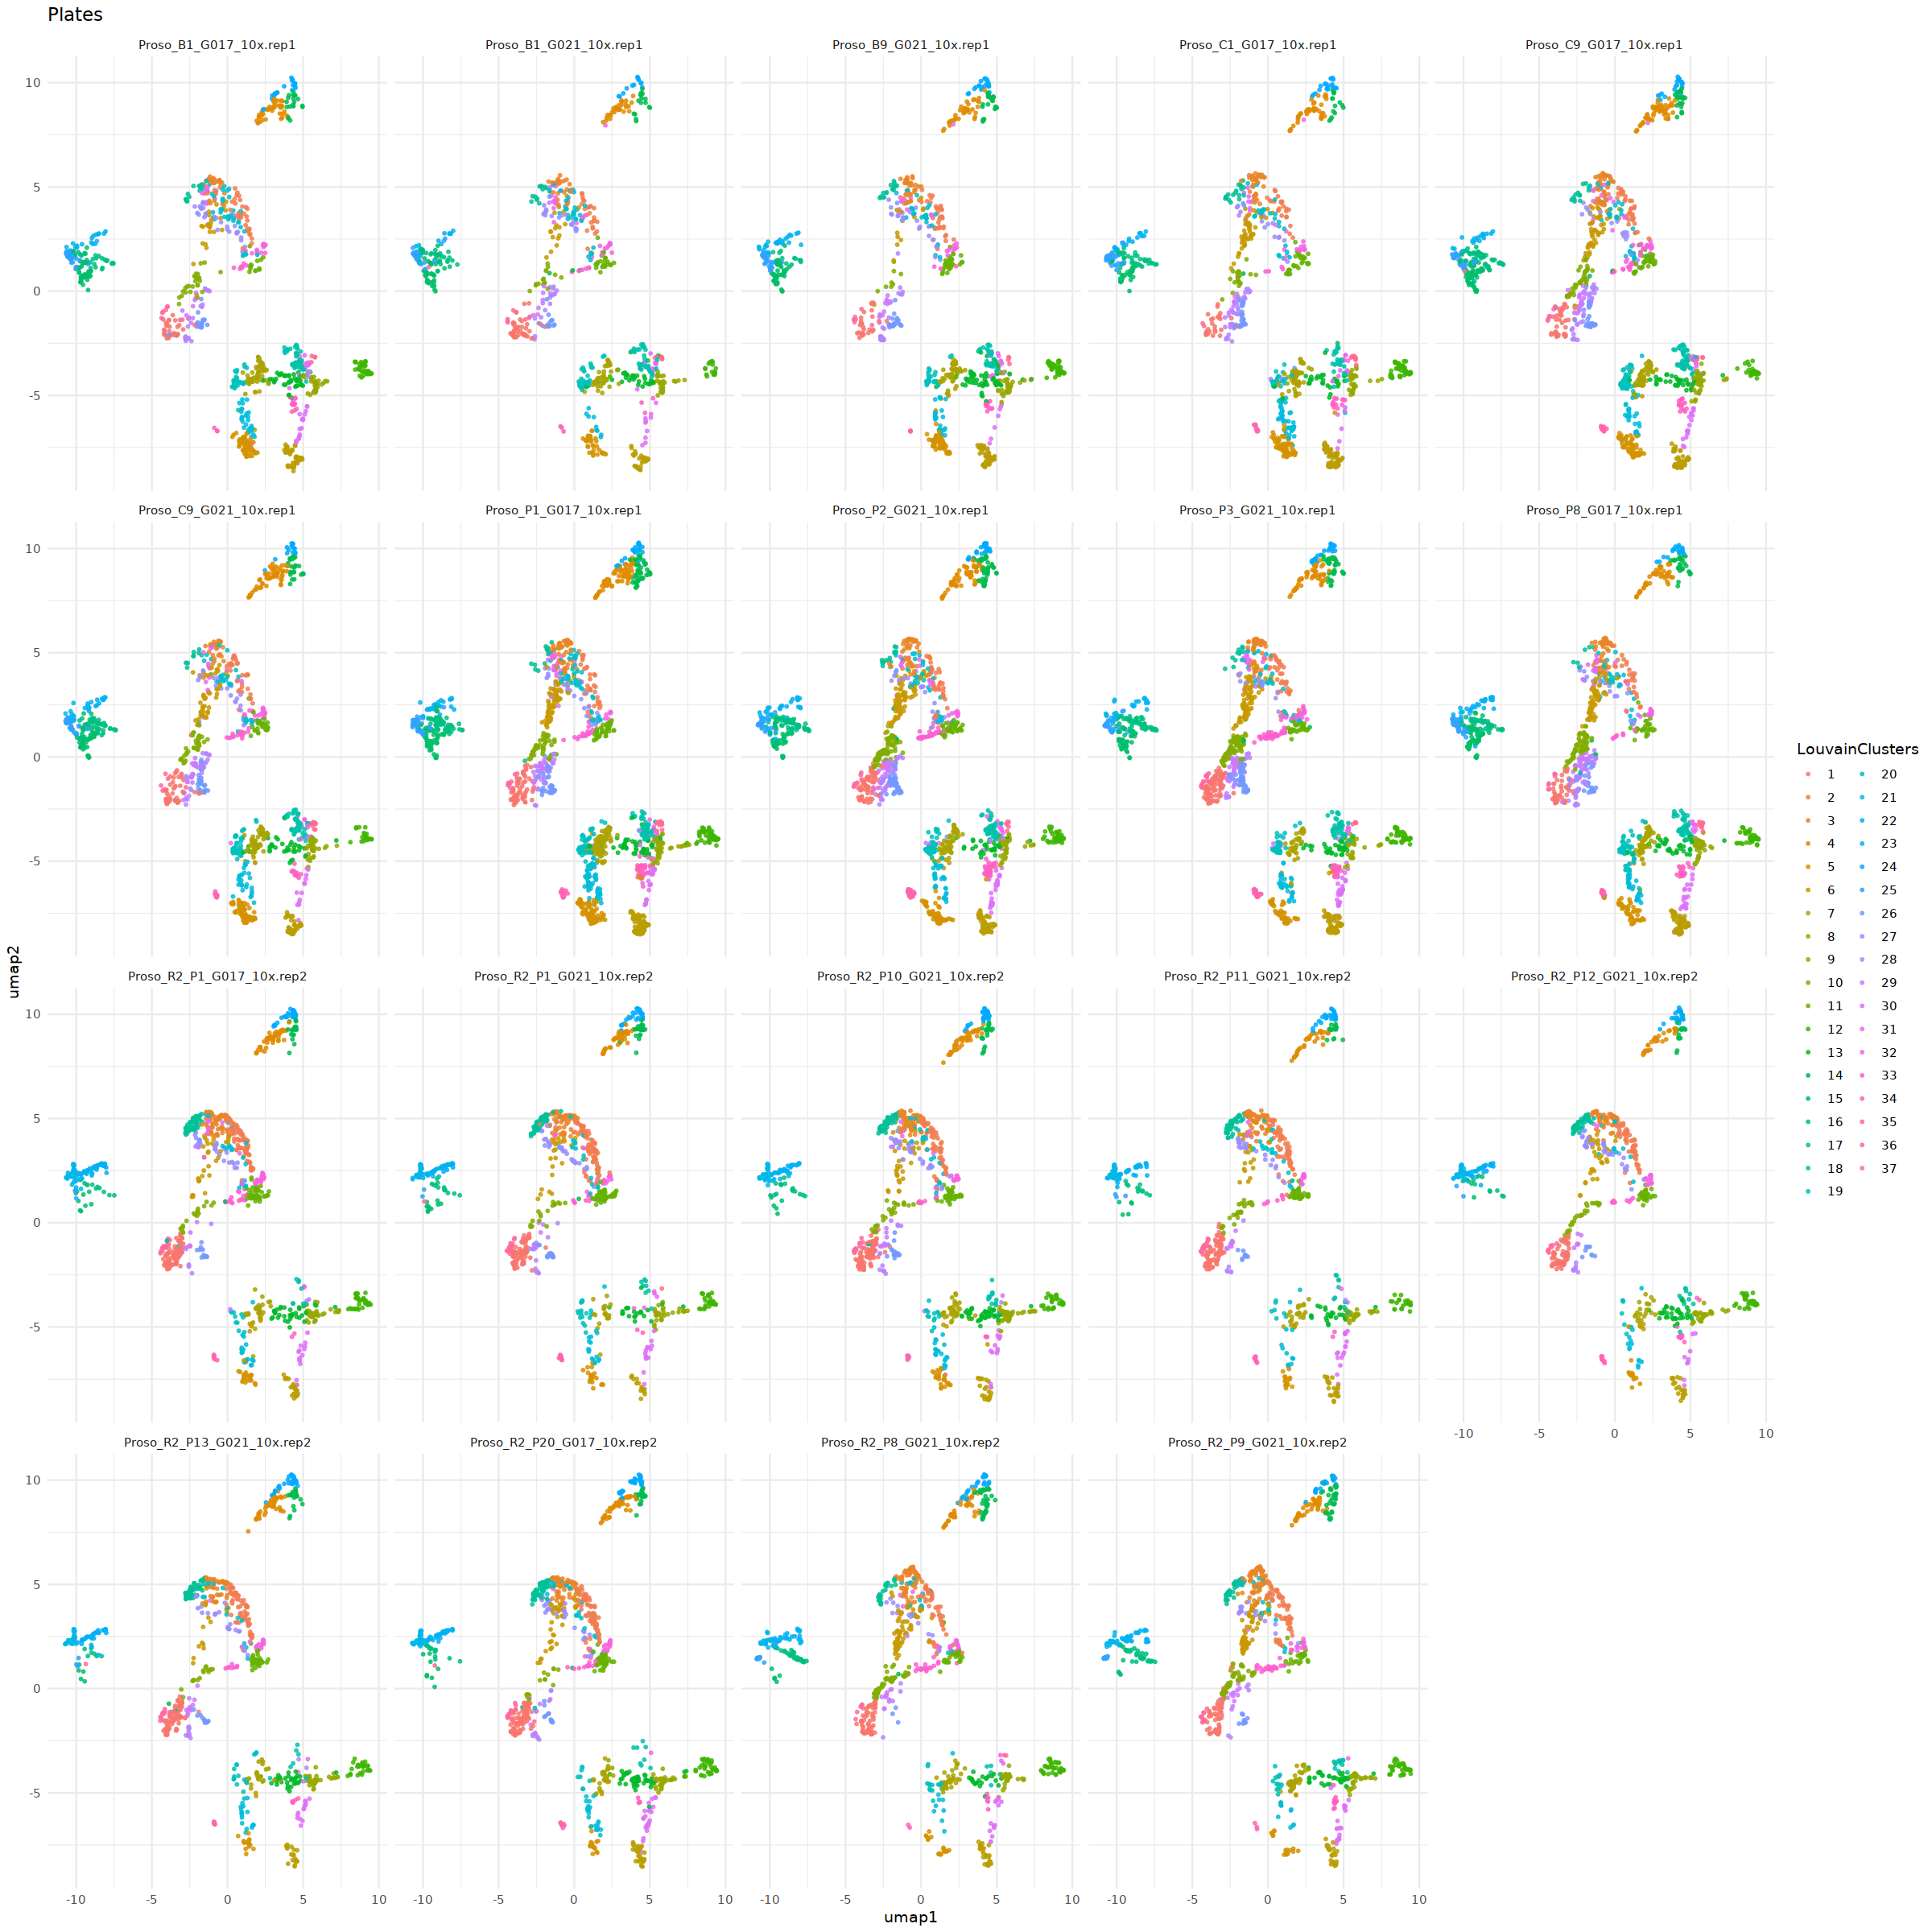

In [134]:
library(tidyverse)
cell_converted_trible_harmony <- as_tibble(tfidf.obj.dob.filt.replace_NMF.clusters$Clusters) %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)

colnames(cell_converted_trible)
options(repr.plot.width=20, repr.plot.height=20)
ggplot(cell_converted_trible_harmony, aes(umap1, umap2, color = LouvainClusters)) + 
    geom_point(size = .6, alpha = .8) + theme_minimal() + ggtitle("Plates") +
    facet_wrap(~plate)

In [137]:
#prefix <- "Sb_leaf.merged_replicates"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/proso_millet/clustering/"
#paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.replace_NMF.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.replace_NMF.clusters$NMF

write.table(nmf.meta, file=paste0(output_location,prefix, ".NMF.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".NMF.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

In [138]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.replace_NMF.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.replace_NMF.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.replace_NMF.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".NMF.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

### Run same Analysis but with SVD

In [2]:
library("here")
library(devtools)
library(Seurat)
library(Socrates)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

rep_1 <- paste0(data_path,"Sb.Leaf_rep1_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Sb.Leaf_rep2_QC_soc_obj.rds")
prefix <- "Pm.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)


# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.0001, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)


# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=25, 
                      num.var=2000,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=20,
                       m.dist=0.01,
                       svd_slotName="SVD")


tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

ℹ Loading Socrates

Warning message:
"replacing previous import 'scales::viridis_pal' by 'viridis::viridis_pal' when loading 'Socrates'"


[1] "Merging Object"
[1] "Generating Socrates Obj"
[1] "Generating Graphs"


   * Input: cells = 17428 | peaks = 1295905

   * Filtered: cells = 17428 | peaks = 106803

 - non-linear dimensionality reduction with UMAP ...

08:59:07 UMAP embedding parameters a = 1.896 b = 0.8006

08:59:07 Read 17428 rows and found 24 numeric columns

08:59:07 Using Annoy for neighbor search, n_neighbors = 20

08:59:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:59:08 Writing NN index file to temp file /tmp/RtmpNHa1Ju/file3d1332c8c62ed

08:59:08 Searching Annoy index using 16 threads, search_k = 2000

08:59:09 Annoy recall = 100%

08:59:11 Commencing smooth kNN distance calibration using 16 threads

08:59:14 Initializing from normalized Laplacian + noise

08:59:14 Commencing optimization for 200 epochs, with 540228 positive edges

08:59:34 Optimization fin

In [3]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.5, 
                                     removeDoublets=T, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID

   * Doublet filtering * Input: cells = 17428 | peaks = 106803

   * Doublet filtering * Filtered (13.1%) : cells = 15151 | peaks = 106803



 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN

Warning message:
"The following arguments are not used: reduction"
Warning message:
"The following arguments are not used: reduction"


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14958
Number of edges: 1035311

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.6875
Number of communities: 21
Elapsed time: 22 seconds


2 singletons identified. 19 final clusters.

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 14804



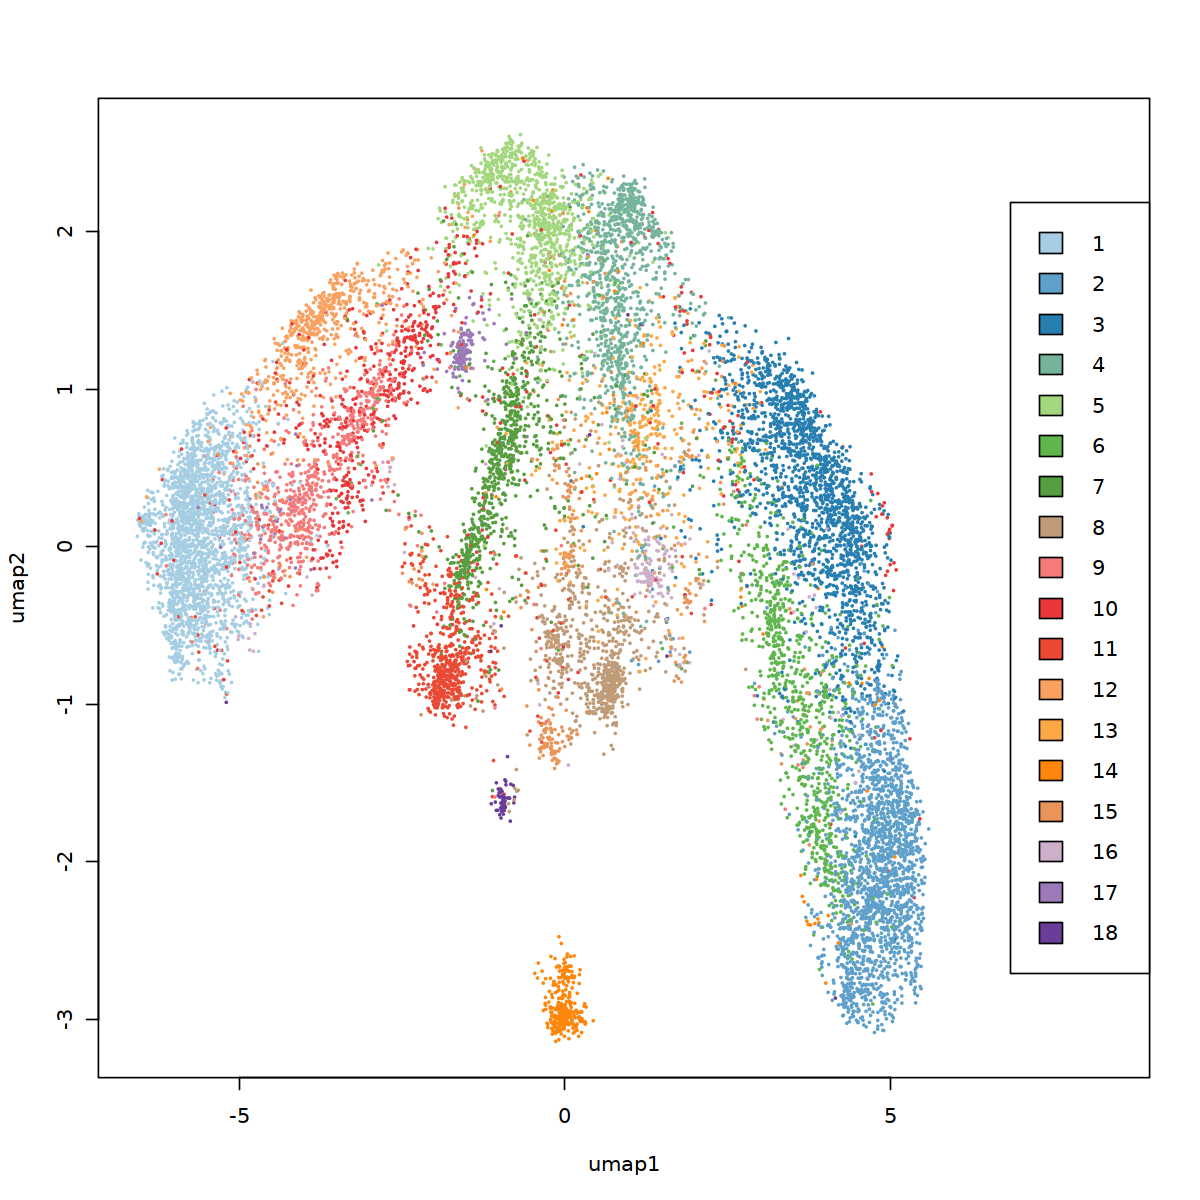

In [4]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt, 
                        res=1.8,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()




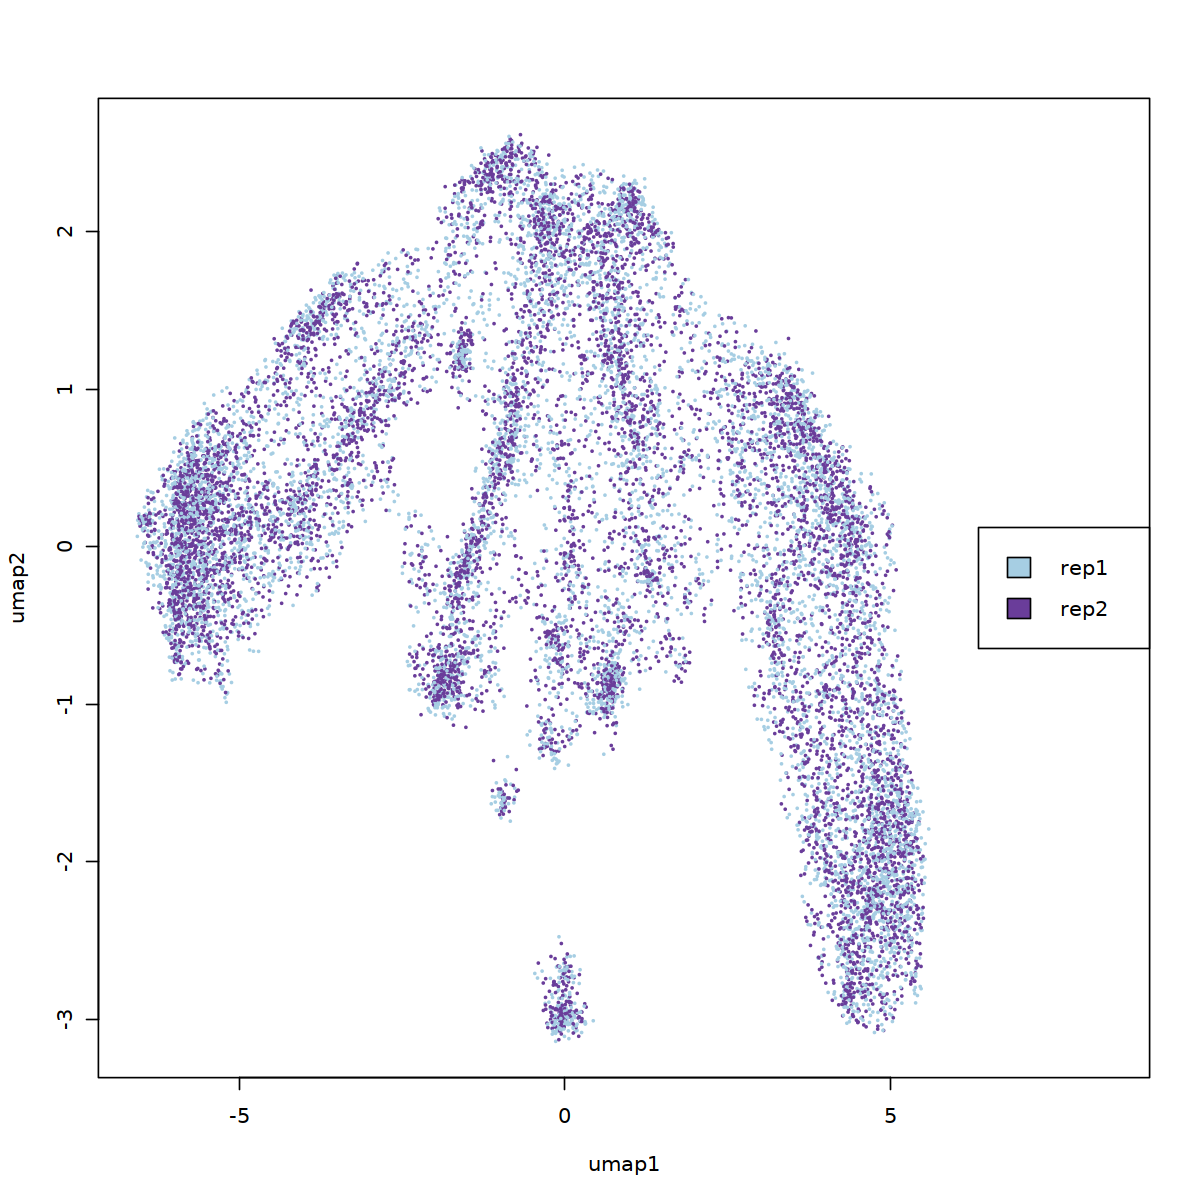

In [5]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [6]:
#prefix <- "Sb_leaf.merged_replicates"

output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"
paste0(data_path, prefix,"SVD.merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


[1] "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb_leaf.merged_replicatesSVD.merged_clusters.sparse"

In [ ]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [9]:
saveRDS(tfidf.obj.dob.filt.clusters, file = paste0(output_location,prefix, ".SVD.full.rds"))

### Final Attempt at clustering with the Regmodel instead of TFIDD

In [4]:
library("here")
library(devtools)
library(Seurat)
library(Socrates)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"


#print("Merging Object")
#merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)


# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.0001, # maximum feature frequency across cells
                     verbose=T)

ℹ Loading Socrates

Warning message:
"replacing previous import 'scales::viridis_pal' by 'viridis::viridis_pal' when loading 'Socrates'"


[1] "Generating Socrates Obj"
[1] "Generating Graphs"


   * Input: cells = 17428 | peaks = 1295905

   * Filtered: cells = 17428 | peaks = 106803



In [5]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- regModel(soc.obj, nthreads = 5)

In [7]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="NMF", 
                      n.pcs=25, 
                      num.var=30000,
                      svd_slotName="NMF")

Warning message in sqrt(row.means):
"NaNs produced"


ERROR: Error in RcppML::nmf(M, n.pcs, verbose = verbose, ...): Not an S4 object.


In [6]:
# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="NMF")


tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "NMF", svd_slotName="NMF")



tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.5, 
                                     removeDoublets=T, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

Warning message in sqrt(row.means):
"NaNs produced"


ERROR: Error in RcppML::nmf(M, n.pcs, verbose = verbose, ...): Not an S4 object.


In [ ]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt, 
                        res=1.8,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()


